Section 1: Title & Problem Statement

# Income Prediction
**Problem:** Identify characteristics associated with a person making more or less than $50,000 per year using census data.
**Goal:** Build a predictive model, compare approaches, and identify key features associated with higher income.

**Datasets:**
- `census_income_learn.csv`: Training data (199,523 rows)
- `census_income_test.csv`: Testing data (99,762 rows)
- `census_income_metadata.txt`: Detailed column descriptions

**Target Variable:**
- `income` (binary): <=50K = 0, >50K = 1

**Class Distribution (Train):**
- <=50K: ~93.8%
- >50K: ~6.2%

**Notes:**
- Instance weight column is ignored for modeling
- Categorical features are encoded for ML models



1️⃣ Import Libraries

In [2]:
# Data manipulation
import pandas as pd
import numpy as np
import sklearn
import statsmodels
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb


# Settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')


2️⃣ Data Loading & Initial Inspection

In [3]:

### Data Loading & Dataset Description

# The Census Income training and test files do not contain column headers.
# We load the data with `header=None` and later assign meaningful column names
# based on the official Census documentation (`census_income_metadata.txt`).
# Additional parameters:
# - skipinitialspace=True: removes leading/trailing spaces in column values
# - low_memory=False: ensures pandas does not guess column types in chunks,
#   which avoids inconsistent data types.


# Load data (files do not contain headers)
train_df = pd.read_csv('census_income_learn.csv', header=None, skipinitialspace=True, low_memory=False)
test_df  = pd.read_csv('census_income_test.csv', header=None, skipinitialspace=True, low_memory=False)

# Define column names
columns = [
    "age", "class_of_worker", "industry_code", "occupation_code", "education",
    "wage_per_hour", "enrolled_in_edu_last_week", "marital_status",
    "major_industry_code", "major_occupation_code", "race", "hispanic_origin",
    "sex", "labor_union_member", "reason_for_unemployment", "employment_status",
    "capital_gains", "capital_losses", "dividends_from_stocks",
    "tax_filer_status", "region_previous_residence", "state_previous_residence",
    "detailed_household_family_status", "household_summary", "instance_weight",
    "migration_change_msa", "migration_change_region",
    "migration_move_within_region", "lived_here_last_year", "migration_sunbelt",
    "num_persons_worked_for_employer", "family_members_under_18",
    "country_birth_father", "country_birth_mother", "country_birth_self",
    "citizenship", "self_employed", "veteran_questionnaire",
    "veterans_benefits", "weeks_worked", "year", "total_income"
]

# Assign column names
train_df.columns = columns
test_df.columns = columns

# Quick overview
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()

Train shape: (199523, 42)
Test shape: (99762, 42)


,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_last_week,marital_status,major_industry_code,major_occupation_code,race,hispanic_origin,sex,labor_union_member,reason_for_unemployment,employment_status,capital_gains,capital_losses,dividends_from_stocks,tax_filer_status,region_previous_residence,state_previous_residence,detailed_household_family_status,household_summary,instance_weight,migration_change_msa,migration_change_region,migration_move_within_region,lived_here_last_year,migration_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_birth_father,country_birth_mother,country_birth_self,citizenship,self_employed,veteran_questionnaire,veterans_benefits,weeks_worked,year,total_income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [4]:
### Data Type Inspection

#After loading the dataset and assigning column names, we inspect the data types of each feature to understand which variables are numerical and which are categorical.  
#This step is critical for guiding feature engineering, encoding strategies, and model selection.

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   age                               199523 non-null  int64  
 1   class_of_worker                   199523 non-null  object 
 2   industry_code                     199523 non-null  int64  
 3   occupation_code                   199523 non-null  int64  
 4   education                         199523 non-null  object 
 5   wage_per_hour                     199523 non-null  int64  
 6   enrolled_in_edu_last_week         199523 non-null  object 
 7   marital_status                    199523 non-null  object 
 8   major_industry_code               199523 non-null  object 
 9   major_occupation_code             199523 non-null  object 
 10  race                              199523 non-null  object 
 11  hispanic_origin                   198649 non-null  o

In [5]:

# --------------------------------------------------
# Step: Data Type Standardization
# --------------------------------------------------
# Based on the Census metadata, features are divided
# into continuous and categorical variables.
# Explicitly enforcing data types ensures consistency,
# avoids silent errors, and improves downstream modeling.
# --------------------------------------------------

# -----------------------------
# Continuous Variables
# -----------------------------
# These variables are numeric by definition and may
# contain non-numeric placeholders in raw data.
continuous_features = [
    'age',
    'wage_per_hour',
    'capital_gains',
    'capital_losses',
    'dividends_from_stocks',
    'num_persons_worked_for_employer',
    'weeks_worked'
]

# Convert continuous features to numeric
# Invalid values are coerced to NaN for later handling
train_df[continuous_features] = train_df[continuous_features].apply(
    pd.to_numeric, errors='coerce'
)
test_df[continuous_features] = test_df[continuous_features].apply(
    pd.to_numeric, errors='coerce'
)

# -----------------------------
# Categorical Variables
# -----------------------------
# Nominal features with discrete values, including
# demographic, employment, migration, and household attributes
categorical_features = [
    "class_of_worker", "industry_code", "occupation_code", "education",
    "enrolled_in_edu_last_week", "marital_status", "major_industry_code",
    "major_occupation_code", "race", "hispanic_origin", "sex",
    "labor_union_member", "reason_for_unemployment", "employment_status",
    "tax_filer_status", "region_previous_residence", "state_previous_residence",
    "detailed_household_family_status", "household_summary",
    "migration_change_msa", "migration_change_region",
    "migration_move_within_region", "lived_here_last_year",
    "migration_sunbelt", "family_members_under_18",
    "country_birth_father", "country_birth_mother", "country_birth_self",
    "citizenship", "self_employed", "veteran_questionnaire",
    "veterans_benefits", "year","total_income"
]

# Convert categorical features to pandas 'category' dtype
# This reduces memory usage and clarifies feature semantics
for col in categorical_features:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')


3️⃣ Exploratory Data Analysis (EDA)



In [6]:
# ==========================================================
# VARIABLE SUMMARY
# ==========================================================
# Create a summary table for all columns in the training dataset
# Includes:
# - Column name
# - Data type
# - Number of unique values (including NaNs)
# - Sample of unique values (first 10)

summary = []

for col in train_df.columns:
    summary.append({
        "column": col,                               # Column name
        "dtype": train_df[col].dtype,                # Data type of the column
        "num_unique": train_df[col].nunique(dropna=False),  # Count of unique values (including NaN)
        "unique_values_sample": train_df[col].unique()[:10]  # Sample of first 10 unique values
    })

# Convert summary to DataFrame for easier visualization
summary_train_df = pd.DataFrame(summary)

# Display the summary table
summary_train_df


,column,dtype,num_unique,unique_values_sample
0,age,int64,91,"[73, 58, 18, 9, 10, 48, 42, 28, 47, 34]"
1,class_of_worker,category,9,"['Not in universe', 'Self-employed-not incorpo..."
2,industry_code,category,52,"[0, 4, 40, 34, 43, 37, 24, 39, 12, 35] Categor..."
3,occupation_code,category,47,"[0, 34, 10, 3, 40, 26, 37, 31, 12, 36] Categor..."
4,education,category,17,"['High school graduate', 'Some college but no ..."
5,wage_per_hour,int64,1240,"[0, 1200, 876, 500, 400, 450, 650, 475, 1100, ..."
6,enrolled_in_edu_last_week,category,3,"['Not in universe', 'High school', 'College or..."
7,marital_status,category,7,"['Widowed', 'Divorced', 'Never married', 'Marr..."
8,major_industry_code,category,24,"['Not in universe or children', 'Construction'..."
9,major_occupation_code,category,15,"['Not in universe', 'Precision production craf..."


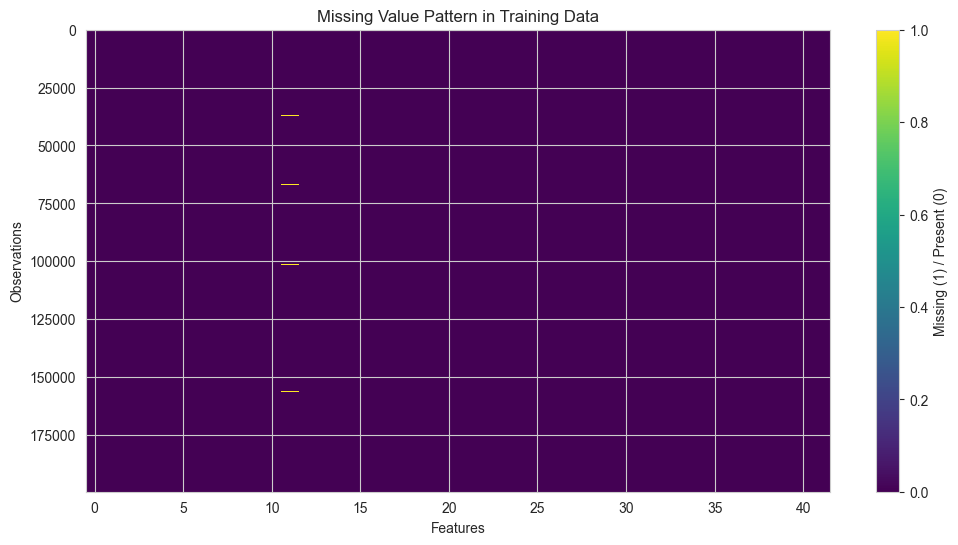

,Feature,Num_Missing,Percent_Missing
11,hispanic_origin,874,0.438045
0,age,0,0.000000
2,industry_code,0,0.000000
3,occupation_code,0,0.000000
4,education,0,0.000000
5,wage_per_hour,0,0.000000
6,enrolled_in_edu_last_week,0,0.000000
7,marital_status,0,0.000000
8,major_industry_code,0,0.000000
1,class_of_worker,0,0.000000


In [7]:
# ==========================================================
# MISSING VALUES ANALYSIS
# ==========================================================

import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 5.1 Visualize missing value pattern
# ----------------------------
plt.figure(figsize=(12,6))
plt.imshow(train_df.isna(), aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('Features')
plt.ylabel('Observations')
plt.title('Missing Value Pattern in Training Data')
plt.colorbar(label='Missing (1) / Present (0)')
plt.show()

# ----------------------------
# 5.2 Create a summary table of missing values
# ----------------------------
missing_summary = train_df.isna().sum().reset_index()
missing_summary.columns = ['Feature', 'Num_Missing']
missing_summary['Percent_Missing'] = (missing_summary['Num_Missing'] / len(train_df)) * 100

# Sort by percentage of missing values descending
missing_summary = missing_summary.sort_values(by='Percent_Missing', ascending=False)

# Display the missing value table
missing_summary


In [8]:
# ==========================================================
# Handling Missing Values and Special Codes
# ==========================================================

# Note:
# Many columns contain missing values encoded as '?', 'NA', or 'Do not know'.
# Some variables (like migration columns) depend on other features for proper imputation.
# We'll systematically clean both training and testing datasets.

# ----------------------------
# 6.1 Hispanic Origin
# ----------------------------
# Fill missing values with 'All other' as a catch-all category.
# This combines NA, Do not know, and missing entries.
train_df['hispanic_origin'].fillna('Do not know', inplace=True)
test_df['hispanic_origin'].fillna('Do not know', inplace=True)

# Check distribution
train_df['hispanic_origin'].value_counts(normalize=True)

# ----------------------------
# 6.2 Replace '?' with 'Not identifiable' for categorical columns
# ----------------------------
replace_cols = ['state_previous_residence', 'country_birth_father',
                'country_birth_mother', 'country_birth_self']

for col in replace_cols:
    train_df[col] = train_df[col].replace(['?'], 'Not identifiable')
    test_df[col] = test_df[col].replace(['?'], 'Not identifiable')

# ----------------------------
# 6.3 Migration-related columns
# ----------------------------
# Migration variables (msa, region, move within region) require contextual imputation:
# - 'Not in universe': when person was <1 year old at previous residence
# - 'Nonmover': person stayed in same location
# - 'Not identifiable': unknown or inconsistent data

import numpy as np

# Function to handle migration columns
def impute_migration(col, df):
    df[col] = df[col].astype(str)
    conditions = [
        (df[col] == '?') & (df['lived_here_last_year'] == 'Not in universe under 1 year old'),
        (df[col] == '?') & (df['lived_here_last_year'] == 'Yes')
    ]
    choices = ['Not in universe', 'Nonmover']
    df[col] = np.select(
        conditions,
        choices,
        default=np.where(df[col] == '?', 'Not identifiable', df[col])
    )
    df[col] = df[col].astype('category')

# Apply to both training and testing datasets
for migration_col in ['migration_change_msa', 'migration_change_region', 'migration_move_within_region']:
    impute_migration(migration_col, train_df)
    impute_migration(migration_col, test_df)

# ----------------------------
# 6.4 Migration Sunbelt
# ----------------------------
# Complex logic:
# - '?', and lived_here_last_year = 'Not in universe under 1 year old' → 'Not in universe'
# - '?', and lived_here_last_year = 'Yes' → 'No' (non-mover)
# - '?', and lived_here_last_year = 'No' → 'Not identifiable'

def clean_migration_sunbelt(df):
    # Strip whitespaces
    df['migration_sunbelt'] = df['migration_sunbelt'].str.strip()
    df['lived_here_last_year'] = df['lived_here_last_year'].str.strip()
    
    # Ensure all new categories exist if column is categorical
    if pd.api.types.is_categorical_dtype(df['migration_sunbelt']):
        for cat in ['Not in universe', 'No', 'Not identifiable']:
            if cat not in df['migration_sunbelt'].cat.categories:
                df['migration_sunbelt'] = df['migration_sunbelt'].cat.add_categories([cat])
    else:
        df['migration_sunbelt'] = df['migration_sunbelt'].astype(str)
    
    # Impute based on conditions
    df.loc[(df['migration_sunbelt'] == '?') & (df['lived_here_last_year'] == 'Not in universe under 1 year old'), 'migration_sunbelt'] = 'Not in universe'
    df.loc[(df['migration_sunbelt'] == '?') & (df['lived_here_last_year'] == 'Yes'), 'migration_sunbelt'] = 'No'
    df.loc[(df['migration_sunbelt'] == '?') & (df['lived_here_last_year'] == 'No'), 'migration_sunbelt'] = 'Not identifiable'
    
    df['migration_sunbelt'] = df['migration_sunbelt'].astype('category')

# Apply to both training and testing datasets
clean_migration_sunbelt(train_df)
clean_migration_sunbelt(test_df)


C:\Users\kazme\AppData\Local\Temp\ipykernel_27736\2737131377.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['hispanic_origin'].fillna('Do not know', inplace=True)
C:\Users\kazme\AppData\Local\Temp\ipykernel_27736\2737131377.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

In [9]:
##check summary
for col in categorical_features:
    print(f"\nColumn: {col}")
    counts = train_df[col].value_counts(dropna=False)
    percentages = train_df[col].value_counts(normalize=True, dropna=False) * 100
    summary = pd.DataFrame({'Count': counts, 'Percentage': percentages})
    print(summary)



Column: class_of_worker
                                 Count  Percentage
class_of_worker                                   
Not in universe                 100245   50.242328
Private                          72028   36.100099
Self-employed-not incorporated    8445    4.232595
Local government                  7784    3.901305
State government                  4227    2.118553
Self-employed-incorporated        3265    1.636403
Federal government                2925    1.465996
Never worked                       439    0.220025
Without pay                        165    0.082697

Column: industry_code
                Count  Percentage
industry_code                    
0              100684   50.462353
33              17070    8.555405
43               8283    4.151401
4                5984    2.999153
42               4683    2.347098
45               4482    2.246358
29               4209    2.109531
37               4022    2.015808
41               3964    1.986738
32               

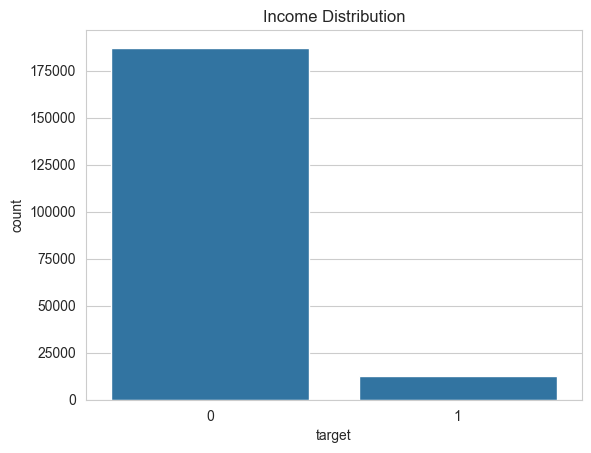

Target proportion:
target
0    0.937942
1    0.062058
Name: proportion, dtype: float64


In [10]:
# ==========================================================
# TARGET VARIABLE
# ==========================================================
# Clean and encode target
train_df["total_income"] = train_df["total_income"].astype(str).str.replace(" ", "").str.replace(".", "", regex=False)
train_df["target"] = train_df["total_income"].map({"-50000": 0, "50000+": 1}).astype(int)
train_df.drop(columns=["total_income"], inplace=True)

### Do Clean and encode test 
test_df["total_income"] = test_df["total_income"].astype(str).str.replace(" ", "").str.replace(".", "", regex=False)
test_df["target"] = test_df["total_income"].map({"-50000": 0, "50000+": 1}).astype(int)
test_df.drop(columns=["total_income"], inplace=True)

# Target distribution
sns.countplot(x='target', data=train_df)
plt.title('Income Distribution')
plt.show()

print("Target proportion:")
print(train_df['target'].value_counts(normalize=True))

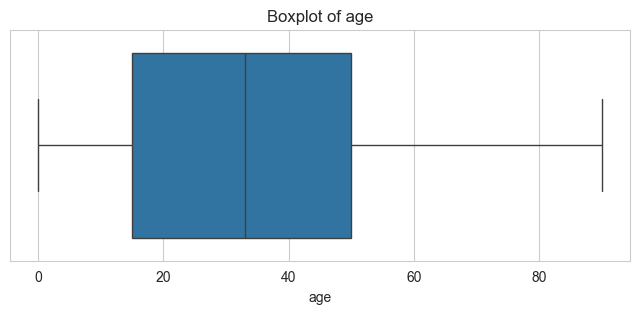

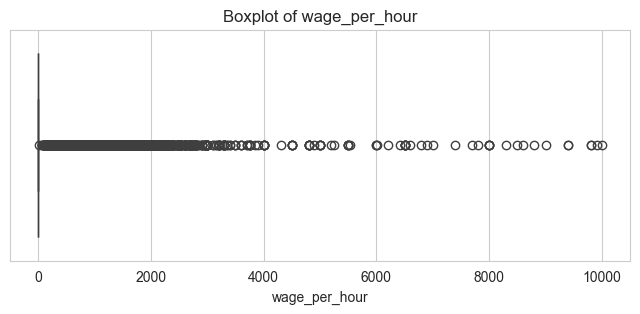

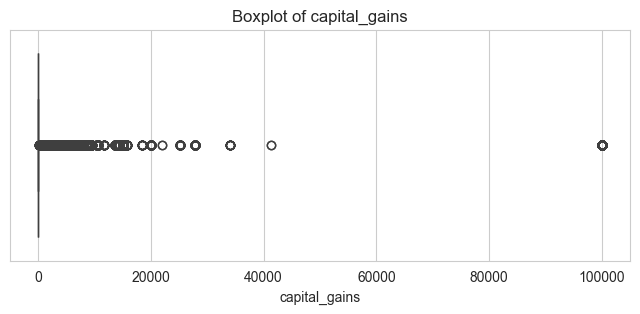

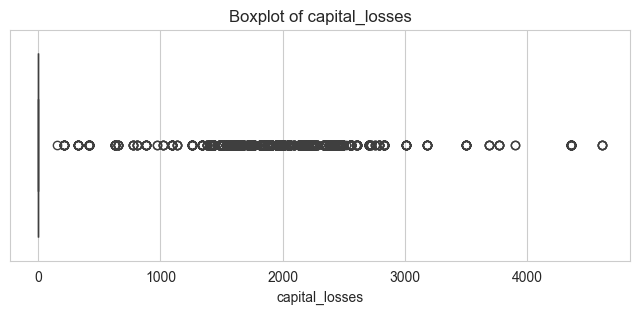

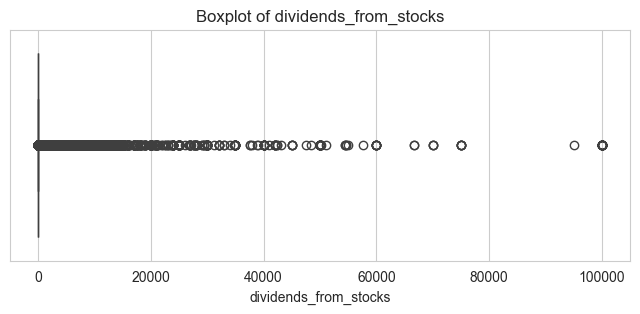

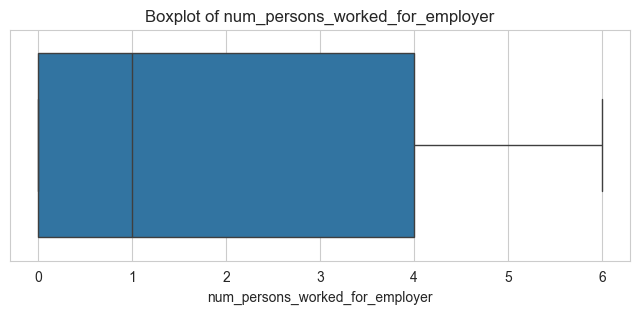

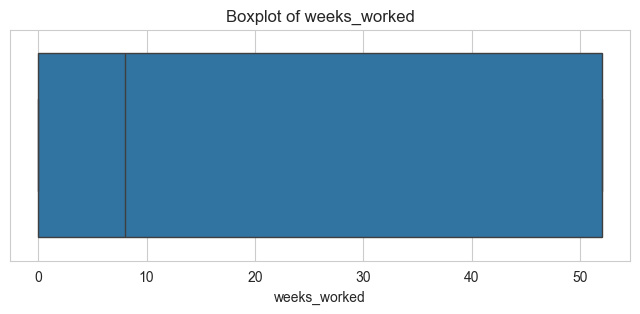

Number of outliers per continuous feature:
 age                                   0
wage_per_hour                      4967
capital_gains                      1460
capital_losses                     3814
dividends_from_stocks              1396
num_persons_worked_for_employer       0
weeks_worked                          0
dtype: int64


In [11]:
# ==========================================================
# CONTINUOUS FEATURE EXPLORATION
# ==========================================================

train_df.describe().T

# Boxplots to detect outliers
for col in continuous_features:
    plt.figure(figsize=(8,3))
    sns.boxplot(x=train_df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Check skewness and extreme values
z_scores = np.abs(stats.zscore(train_df[continuous_features]))
outliers = (z_scores > 3).sum(axis=0)
print("Number of outliers per continuous feature:\n", outliers)

In [12]:
for col in categorical_features:
    if col in train_df.columns:
        print(f"\nColumn: {col}")
        counts = train_df[col].value_counts(dropna=False)
        percentages = train_df[col].value_counts(normalize=True, dropna=False) * 100
        summary = pd.DataFrame({'Count': counts, 'Percentage': percentages})
        print(summary)
    else:
        print(f"\nColumn '{col}' not found in train_df")



Column: class_of_worker
                                 Count  Percentage
class_of_worker                                   
Not in universe                 100245   50.242328
Private                          72028   36.100099
Self-employed-not incorporated    8445    4.232595
Local government                  7784    3.901305
State government                  4227    2.118553
Self-employed-incorporated        3265    1.636403
Federal government                2925    1.465996
Never worked                       439    0.220025
Without pay                        165    0.082697

Column: industry_code
                Count  Percentage
industry_code                    
0              100684   50.462353
33              17070    8.555405
43               8283    4.151401
4                5984    2.999153
42               4683    2.347098
45               4482    2.246358
29               4209    2.109531
37               4022    2.015808
41               3964    1.986738
32               

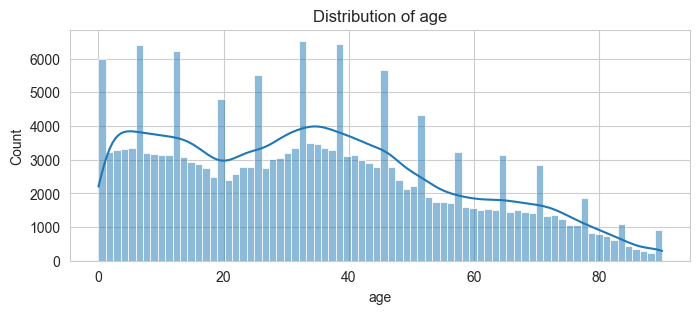

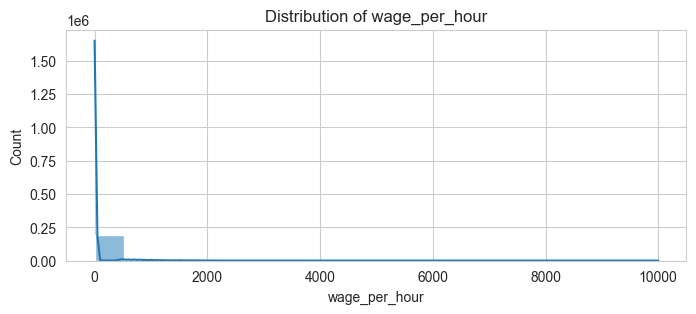

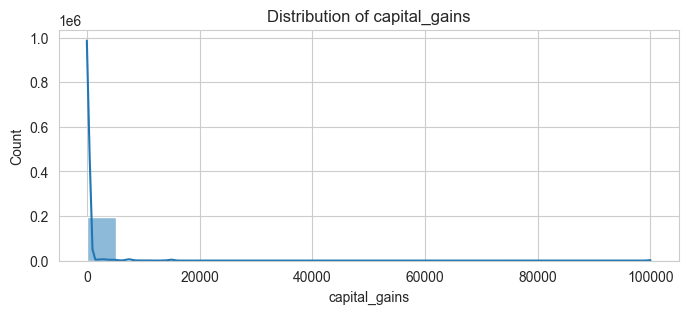

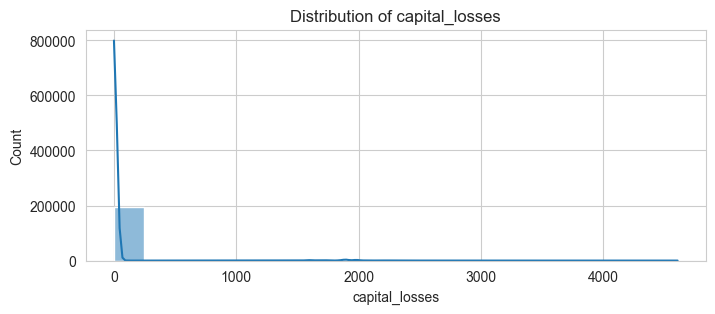

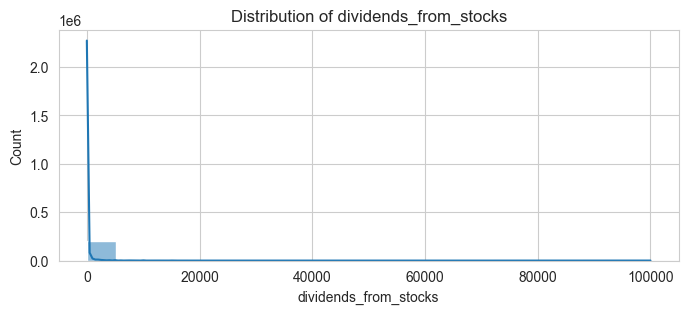

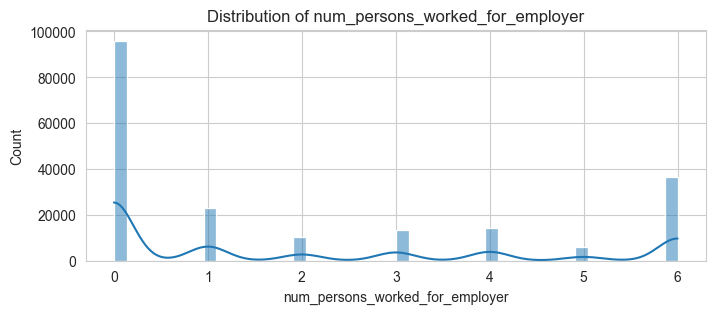

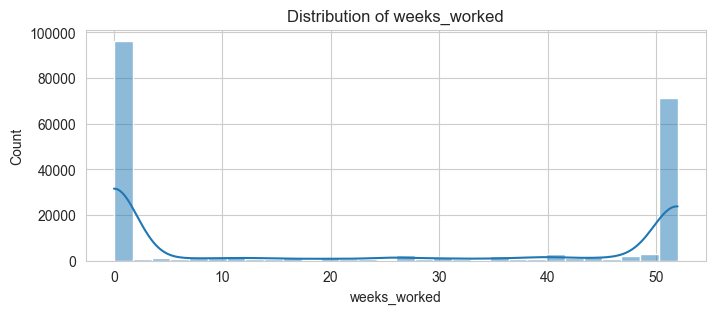

In [13]:
# ==========================================================
# OUTLIER HANDLING & LOG TRANSFORM
# ==========================================================

# Cap and log-transform
for col in ['wage_per_hour','capital_gains','capital_losses','dividends_from_stocks']:
    upper = train_df[col].quantile(0.99)
    train_df[f'{col}_cap'] = train_df[col].clip(upper=upper)
    train_df[f'{col}_log'] = np.log1p(train_df[f'{col}_cap'])

# --- Testing dataset ---
for col in ['wage_per_hour','capital_gains','capital_losses','dividends_from_stocks']:
    upper = test_df[col].quantile(0.99)
    test_df[f'{col}_cap'] = test_df[col].clip(upper=upper)
    test_df[f'{col}_log'] = np.log1p(test_df[f'{col}_cap'])


# Optional: histogram plots for Skewness Distribution
for col in continuous_features:
    plt.figure(figsize=(8,3))
    sns.histplot(train_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [14]:
train_df.describe().T


,count,mean,std,min,25%,50%,75%,max
age,199523.0,34.494199,22.310895,0.00,15.000,33.00,50.00,90.000000
wage_per_hour,199523.0,55.426908,274.896454,0.00,0.000,0.00,0.00,9999.000000
capital_gains,199523.0,434.718990,4697.531280,0.00,0.000,0.00,0.00,99999.000000
capital_losses,199523.0,37.313788,271.896428,0.00,0.000,0.00,0.00,4608.000000
dividends_from_stocks,199523.0,197.529533,1984.163658,0.00,0.000,0.00,0.00,99999.000000
instance_weight,199523.0,1740.380269,993.768156,37.87,1061.615,1618.31,2188.61,18656.300000
num_persons_worked_for_employer,199523.0,1.956180,2.365126,0.00,0.000,1.00,4.00,6.000000
weeks_worked,199523.0,23.174897,24.411488,0.00,0.000,8.00,52.00,52.000000
target,199523.0,0.062058,0.241261,0.00,0.000,0.00,0.00,1.000000
wage_per_hour_cap,199523.0,49.558271,218.197568,0.00,0.000,0.00,0.00,1400.000000


In [15]:
import pandas as pd

# Filter categorical_features to only those present in train_df
existing_cat_features = [col for col in categorical_features if col in train_df.columns]

# Create summary table
cat_summary = pd.DataFrame({
    "Feature": existing_cat_features,
    "Unique_Values": [train_df[col].nunique(dropna=False) for col in existing_cat_features],
    "Data_Type": [train_df[col].dtype for col in existing_cat_features]
}).sort_values(by="Unique_Values", ascending=False)

display(cat_summary)


,Feature,Unique_Values,Data_Type
1,industry_code,52,category
16,state_previous_residence,51,category
2,occupation_code,47,category
27,country_birth_self,43,category
26,country_birth_mother,43,category
25,country_birth_father,43,category
17,detailed_household_family_status,38,category
6,major_industry_code,24,category
3,education,17,category
7,major_occupation_code,15,category


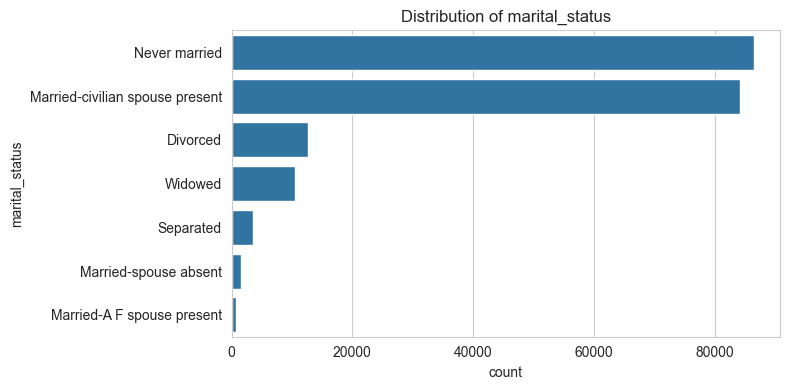

C:\Users\kazme\AppData\Local\Temp\ipykernel_27736\1634570937.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop = df.groupby(col)[target].mean().sort_values(ascending=False)


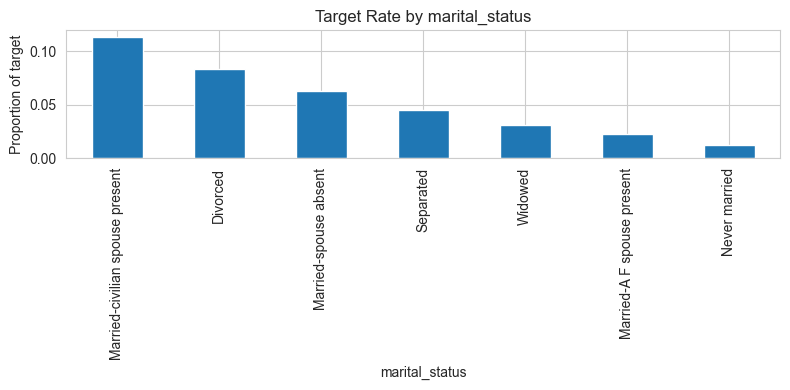

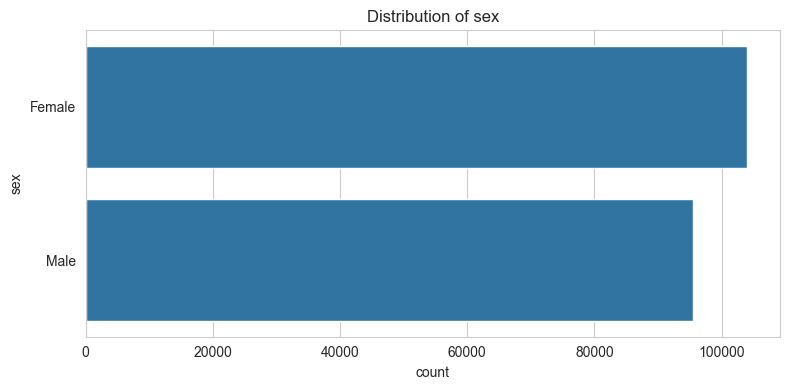

C:\Users\kazme\AppData\Local\Temp\ipykernel_27736\1634570937.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop = df.groupby(col)[target].mean().sort_values(ascending=False)


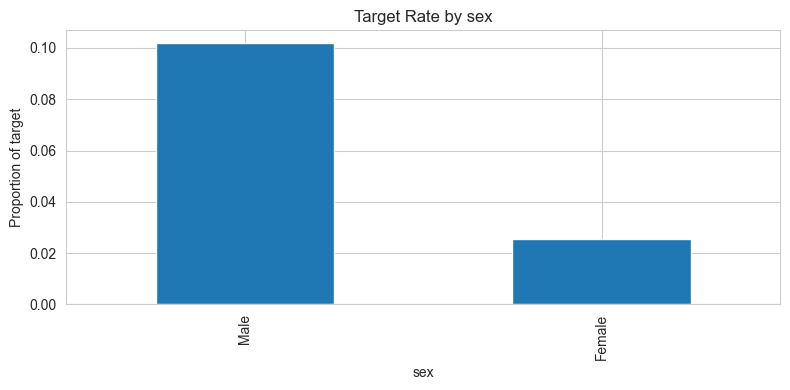

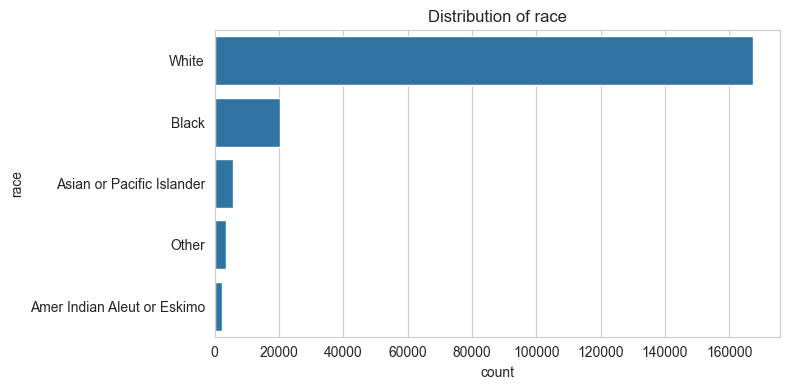

C:\Users\kazme\AppData\Local\Temp\ipykernel_27736\1634570937.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop = df.groupby(col)[target].mean().sort_values(ascending=False)


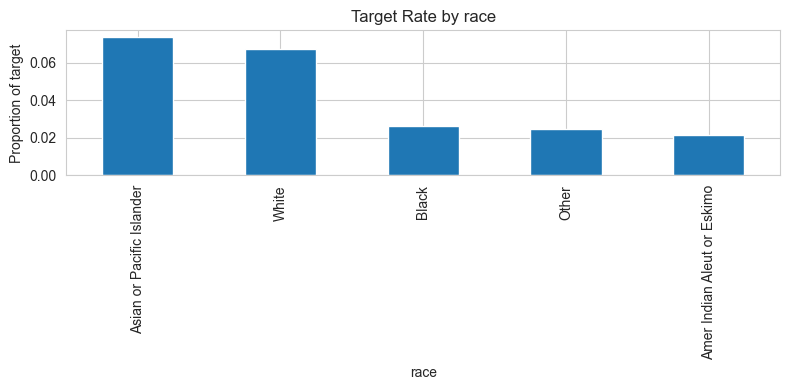

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_categorical_features(df, features, target='target', max_unique=10):
    """
    Plots countplots and target rate for selected categorical features.
    
    Parameters:
    - df: DataFrame
    - features: list of column names to plot
    - target: target column name
    - max_unique: only plot features with <= max_unique unique values
    """
    # Filter features based on unique values
    features_to_plot = [col for col in features if df[col].nunique() <= max_unique]
    
    for col in features_to_plot:
        # Countplot
        plt.figure(figsize=(8,4))
        sns.countplot(y=col, data=df, order=df[col].value_counts().index)
        plt.title(f'Distribution of {col}')
        plt.tight_layout()
        plt.show()
        
        # Target rate
        prop = df.groupby(col)[target].mean().sort_values(ascending=False)
        plt.figure(figsize=(8,4))
        prop.plot(kind='bar')
        plt.ylabel(f'Proportion of {target}')
        plt.title(f'Target Rate by {col}')
        plt.tight_layout()
        plt.show()

# Example usage:
# Select features you want to visualize
selected_features = ['marital_status', 'sex', 'education',  'race']
plot_categorical_features(train_df, selected_features)


Feature Engineering : The Transformation Logic

In [17]:
# Feature Engineering: Migration Change MSA
# -----------------------------
# The original column 'migration_change_msa' contains detailed categories describing
# a person's migration status, including domestic moves, international moves, 
# non-movers, and not identifiable/missing values. To simplify and improve interpretability,
# we collapse it into 4 meaningful categories:
# 1. 'Nonmover'          -> People who did not move or are not in universe
# 2. 'Domestic move'     -> Any move within the country (MSA or Non-MSA)
# 3. 'International move' -> Moves coming from abroad
# 4. 'Not identifiable'  -> Unknown, missing, or unexpected categories
# This reduces high cardinality, preserves meaningful groups, and is suitable for modeling.
# -----------------------------

# Define mapping function
def collapse_migration_change_msa(x):
    if x in ['Not in universe', 'Nonmover']:
        return 'Nonmover'
    elif x in ['MSA to MSA', 'NonMSA to nonMSA', 'MSA to nonMSA', 'NonMSA to MSA']:
        return 'Domestic move'
    elif x in ['Abroad to MSA', 'Abroad to nonMSA']:
        return 'International move'
    elif x == 'Not identifiable':
        return 'Not identifiable'
    

# Apply mapping
train_df['migration_change_msa_grouped'] = train_df['migration_change_msa'].apply(collapse_migration_change_msa)

# Convert to categorical
train_df['migration_change_msa_grouped'] = train_df['migration_change_msa_grouped'].astype('category')

# Optional: check distribution
print(train_df['migration_change_msa_grouped'].value_counts(normalize=True))


### For Testing dataset : Feature Engineering 

# Apply the same mapping to test data
test_df['migration_change_msa_grouped'] = test_df['migration_change_msa'].apply(collapse_migration_change_msa)

# Convert to categorical
test_df['migration_change_msa_grouped'] = test_df['migration_change_msa_grouped'].astype('category')




migration_change_msa_grouped
Nonmover              0.920946
Domestic move         0.074262
International move    0.002636
Not identifiable      0.002155
Name: proportion, dtype: float64


In [18]:
# Feature Engineering: Previous Residence Type
# -----------------------------
# The original column 'region_previous_residence' contains detailed information
# about where the person previously lived. To simplify and create an interpretable feature,
# we collapse it into 3 meaningful categories:
# 1. 'International'     -> Previously lived abroad
# 2. 'Domestic'          -> Previously lived within US regions (Northeast, Midwest, South, West)
# 3. 'Not_in_Universe'   -> Respondent not in universe for this question
# This reduces complexity, improves interpretability, and is suitable for modeling.
# -----------------------------

def prev_residence_type(prev_region):
    if prev_region == 'Abroad':
        return 'International'
    elif prev_region in ['Northeast', 'Midwest', 'South', 'West']:
        return 'Domestic'
    elif prev_region == 'Not in universe':
        return 'Not_in_Universe'


train_df['prev_residence_type'] = train_df['region_previous_residence'].apply(prev_residence_type)
train_df['prev_residence_type'] = train_df['prev_residence_type'].astype('category')

# Optional: check distribution
print(train_df['prev_residence_type'].value_counts(normalize=True))

test_df['prev_residence_type'] = test_df['region_previous_residence'].apply(prev_residence_type)
test_df['prev_residence_type'] = test_df['prev_residence_type'].astype('category')



prev_residence_type
Not_in_Universe    0.920946
Domestic           0.076397
International      0.002656
Name: proportion, dtype: float64


In [19]:

# -----------------------------
# Feature Engineering: Hispanic Origin
# -----------------------------
# The original column 'hispanic_origin' contains multiple subgroups and 'All other'.
# To simplify and create an interpretable feature, we collapse it into 3 meaningful categories:
# 1. 'Hispanic'            -> Combines all Hispanic subgroups
# 2. 'Non-Hispanic'        -> All other respondents explicitly labeled as 'All other'
# 3. 'Unknown / Do not know' -> Any missing, unknown, or unexpected values
# This approach reduces complexity, preserves interpretability, and is suitable for modeling.
# -----------------------------

def hispanic_binary(x):
    if x in ['Mexican (Mexicano)', 'Mexican-American', 'Chicano',
             'Puerto Rican', 'Cuban',
             'Central or South American', 'Other Spanish']:
        return 'Hispanic'             # Hispanic
    elif x in ['All other']:
        return 'Non-Hispanic'         # Non-Hispanic
    else:
        return 'Unknown / Do not know' # Unknown / Do not know

train_df['is_hispanic'] = train_df['hispanic_origin'].apply(hispanic_binary).astype('category')

# Optional: check distribution
print(train_df['is_hispanic'].value_counts(normalize=True))
test_df['is_hispanic'] = test_df['hispanic_origin'].apply(hispanic_binary).astype('category')


is_hispanic
Non-Hispanic             0.861590
Hispanic                 0.132496
Unknown / Do not know    0.005914
Name: proportion, dtype: float64


In [20]:
# -----------------------------
# Feature Engineering: Reason for Unemployment
# -----------------------------
# The original column 'reason_for_unemployment' contains detailed reasons why
# a person may be unemployed. To simplify and create meaningful groups for modeling,
# we collapse it into the following categories:
# 1. 'Job_Loser'       -> Individuals who lost their job (layoff or other job loss)
# 2. 'Job_Leaver'      -> Individuals who voluntarily left their job
# 3. 'New_Entrant'     -> Individuals entering the workforce for the first time
# 4. 'Re_Entrant'      -> Individuals re-entering the workforce
# 5. 'Not_in_Universe' -> Not applicable / not in universe for this question
# 6. 'Unknown'         -> Any unexpected or missing value
# This reduces high cardinality, preserves interpretability, and is suitable for modeling.
# -----------------------------

def unemp_reason_group(x):
    if x in ['Job loser - on layoff', 'Other job loser']:
        return 'Job_Loser'
    elif x == 'Job leaver':
        return 'Job_Leaver'
    elif x == 'New entrant':
        return 'New_Entrant'
    elif x == 'Re-entrant':
        return 'Re_Entrant'
    elif x == 'Not in universe':
        return 'Not_in_Universe'
    else:
        return 'Unknown'

train_df['unemp_reason_grp'] = train_df['reason_for_unemployment'].apply(unemp_reason_group).astype('category')

# Optional: check distribution in train set
print(train_df['unemp_reason_grp'].value_counts(normalize=True))

# Apply the same mapping to test dataset for consistency
test_df['unemp_reason_grp'] = test_df['reason_for_unemployment'].apply(unemp_reason_group).astype('category')

unemp_reason_grp
Not_in_Universe    0.969577
Job_Loser          0.015106
Re_Entrant         0.010119
Job_Leaver         0.002997
New_Entrant        0.002200
Name: proportion, dtype: float64


In [21]:
# -----------------------------
# Feature Engineering: Class of Worker
# -----------------------------
# The original column 'class_of_worker' contains detailed categories describing 
# a person's employment type. To simplify and create meaningful groups, we collapse it into:
# 1. 'Private'           -> Private sector workers
# 2. 'Government'        -> Local, State, or Federal government employees
# 3. 'Self-employed'     -> Both incorporated and non-incorporated self-employed individuals
# 4. 'Marginal'          -> Individuals who never worked or worked without pay
# 5. 'Not in labor force'-> Individuals not in the labor force
# This reduces high cardinality, improves interpretability, and is suitable for modeling.
# -----------------------------

train_df['worker_grouped'] = train_df['class_of_worker'].map({
    'Private': 'Private',
    'Local government': 'Government',
    'State government': 'Government',
    'Federal government': 'Government',
    'Self-employed-incorporated': 'Self-employed',
    'Self-employed-not incorporated': 'Self-employed',
    'Never worked': 'Marginal',
    'Without pay': 'Marginal',
    'Not in universe': 'Not in labor force'
}).astype('category')


# Apply the same mapping to test dataset for consistency
test_df['worker_grouped'] = test_df['class_of_worker'].map({
    'Private': 'Private',
    'Local government': 'Government',
    'State government': 'Government',
    'Federal government': 'Government',
    'Self-employed-incorporated': 'Self-employed',
    'Self-employed-not incorporated': 'Self-employed',
    'Never worked': 'Marginal',
    'Without pay': 'Marginal',
    'Not in universe': 'Not in labor force'
}).astype('category')

pd.crosstab(train_df['worker_grouped'], train_df['target'], normalize='index')



target,0,1
worker_grouped,,
Government,0.870849,0.129151
Marginal,0.995033,0.004967
Not in labor force,0.990982,0.009018
Private,0.898345,0.101655
Self-employed,0.810077,0.189923


In [22]:
# -----------------------------
# Feature Engineering: In Labor Force
# -----------------------------
# The original column 'employment_status' contains detailed work schedules and 
# unemployment types. To create a simple indicator, we define 'In Labor Force' as:
# 'Yes' -> Individuals who are employed (full-time or part-time) or actively unemployed
# 'No'  -> Individuals not in the labor force
# This improves interpretability and is suitable for modeling.
# -----------------------------

train_df['in_labor_force'] = train_df['employment_status'].isin([
    'Full-time schedules',
    'Unemployed part- time',
    'PT for econ reasons usually PT',
    'PT for non-econ reasons usually FT',
    'PT for econ reasons usually FT',
    'Unemployed full-time'
]).map({True: 'Yes', False: 'No'}).astype('category')

test_df['in_labor_force'] = test_df['employment_status'].isin([
    'Full-time schedules',
    'Unemployed part- time',
    'PT for econ reasons usually PT',
    'PT for non-econ reasons usually FT',
    'PT for econ reasons usually FT',
    'Unemployed full-time'
]).map({True: 'Yes', False: 'No'}).astype('category')

# Optional: check distribution
print(train_df['in_labor_force'].value_counts(normalize=True))


in_labor_force
No     0.754685
Yes    0.245315
Name: proportion, dtype: float64


In [23]:
# -----------------------------
# Feature Engineering: Part-Time Attachment
# -----------------------------
# The original column 'employment_status' contains detailed work schedules.
# We define a new feature 'is_part_time' to indicate whether an individual
# is attached to a part-time schedule (only meaningful if employed):
# 'Yes' -> Part-time for economic reasons (usually PT)
# 'No'  -> All other employment statuses
# -----------------------------

train_df['is_part_time'] = train_df['employment_status'].isin([
    'PT for econ reasons usually PT'
]).map({True: 'Yes', False: 'No'}).astype('category')

test_df['is_part_time'] = test_df['employment_status'].isin([
    'PT for econ reasons usually PT'
]).map({True: 'Yes', False: 'No'}).astype('category')

# Optional: check distribution
print(train_df['is_part_time'].value_counts(normalize=True))

pd.crosstab(train_df['is_part_time'], train_df['target'], normalize='index')



is_part_time
No     0.993941
Yes    0.006059
Name: proportion, dtype: float64


target,0,1
is_part_time,,
No,0.938345,0.061655
Yes,0.871795,0.128205


In [24]:
# -----------------------------
# Feature Engineering: Involuntary Part-Time
# -----------------------------
# The original column 'employment_status' contains information about part-time work.
# We define 'involuntary_pt' as an indicator for individuals working part-time 
# for economic reasons (i.e., not by choice):
# 'Yes' -> Part-time for economic reasons
# 'No'  -> All other employment statuses
# -----------------------------

train_df['involuntary_pt'] = train_df['employment_status'].str.contains('econ reasons', case=False).map({True: 'Yes', False: 'No'}).astype('category')

# Optional: check distribution
print(train_df['involuntary_pt'].value_counts(normalize=True))

test_df['involuntary_pt'] = test_df['employment_status'].str.contains('econ reasons', case=False).map({True: 'Yes', False: 'No'}).astype('category')



involuntary_pt
No     0.97466
Yes    0.02534
Name: proportion, dtype: float64


In [25]:
# -----------------------------
# Feature Engineering: Tax-related Features
# -----------------------------

# Feature 1: Filed a Tax Return
# -----------------------------
# Original column 'tax_filer_status' contains filing status information.
# 'is_tax_filer' indicates whether the individual filed a tax return:
# 'Yes' -> Filed a tax return (any status except 'Nonfiler')
# 'No'  -> Did not file ('Nonfiler')
# This is known to be a strong signal for income.
# -----------------------------
train_df['is_tax_filer'] = (train_df['tax_filer_status'] != 'Nonfiler').map({True: 'Yes', False: 'No'}).astype('category')

# Optional: check distribution
print(train_df['is_tax_filer'].value_counts(normalize=True))


# Feature 2: Filing Type
# -----------------------------
# Simplify filing type into 3 meaningful categories:
# 1. 'Joint'  -> Married joint filers
# 2. 'Single' -> Single filers
# 3. 'Head'   -> Head of household
# 4. 'None'   -> Any other or unknown filing types
# This helps capture structural differences in tax filing behavior.
# -----------------------------
def filing_type(x):
    if isinstance(x, str):
        if x.startswith('Joint'):
            return 'Joint'
        elif x == 'Single':
            return 'Single'
        elif x == 'Head of household':
            return 'Head'

train_df['filing_type'] = train_df['tax_filer_status'].apply(filing_type).astype('category')

# Optional: check distribution
print(train_df['filing_type'].value_counts(normalize=True))


# Feature 3: Senior Tax Status (65+ indicator)
# -----------------------------
# Identify senior filers based on age indication in 'tax_filer_status':
# 'Yes' -> 65+ included in the filing status
# 'No'  -> Others
# Captures age-related income differences.
# -----------------------------
def senior_filer(x):
    if isinstance(x, str) and '65+' in x:
        return 'Yes'
    else:
        return 'No'

train_df['senior_tax_filer'] = train_df['tax_filer_status'].apply(senior_filer).astype('category')

# Optional: check distribution
print(train_df['senior_tax_filer'].value_counts(normalize=True))

# Apply the same transformations to test dataset

# Feature 1: Filed a Tax Return
test_df['is_tax_filer'] = (test_df['tax_filer_status'] != 'Nonfiler').map({True: 'Yes', False: 'No'}).astype('category')

# Feature 2: Filing Type
test_df['filing_type'] = test_df['tax_filer_status'].apply(filing_type).astype('category')

# Feature 3: Senior Tax Status
test_df['senior_tax_filer'] = test_df['tax_filer_status'].apply(senior_filer).astype('category')


is_tax_filer
Yes    0.623632
No     0.376368
Name: proportion, dtype: float64
filing_type
Joint     0.639578
Single    0.300742
Head      0.059681
Name: proportion, dtype: float64
senior_tax_filer
No     0.938859
Yes    0.061141
Name: proportion, dtype: float64


In [26]:

# ----------------------------------------
# Feature: Grouped Major Industry
# ----------------------------------------
# The original 'major_industry_code' variable contains many granular industry categories.
# High cardinality makes modeling noisy and harder to interpret.
#
# We collapse industries into 5 economically meaningful macro-sectors:
#
# 1. Primary     -> Resource extraction (Agriculture, Mining, Forestry)
# 2. Industrial  -> Manufacturing, Construction, Utilities
# 3. Commercial  -> Trade, Finance, Communications
# 4. Services    -> Business, Personal, Entertainment services
# 5. Public      -> Government, Education, Healthcare, Armed Forces
#
# Any remaining or rare categories are grouped as 'Other'.
#
# This reduces dimensionality, improves model stability,
# and aligns with standard economic sector classifications.

# This grouping is applied consistently to both training
# and testing datasets to avoid category mismatch during inference.
# ----------------------------------------


def group_major_industry(industry):
    if industry in [
        'Agriculture',
        'Mining',
        'Forestry and fisheries'
    ]:
        return 'Primary'

    elif industry in [
        'Manufacturing-durable goods',
        'Manufacturing-nondurable goods',
        'Construction',
        'Utilities and sanitary services'
    ]:
        return 'Industrial'

    elif industry in [
        'Retail trade',
        'Wholesale trade',
        'Communications',
        'Finance insurance and real estate'
    ]:
        return 'Commercial'

    elif industry in [
        'Business and repair services',
        'Other professional services',
        'Personal services except private HH',
        'Entertainment',
        'Private household services'
    ]:
        return 'Services'

    elif industry in [
        'Education',
        'Medical except hospital',
        'Hospital services',
        'Social services',
        'Public administration',
        'Armed Forces'
    ]:
        return 'Public'

    else:
        return 'Other'

train_df['group_industry'] = train_df['major_industry_code'].apply(group_major_industry).astype('category')
test_df['group_industry'] = (test_df['major_industry_code'].apply(group_major_industry).astype('category'))

# Optional: check distribution
print(train_df['group_industry'].value_counts(normalize=True))

pd.crosstab(
    train_df['group_industry'],
    train_df['target'],
    normalize='index'
)

group_industry
Other         0.525719
Commercial    0.140295
Public        0.120913
Industrial    0.115646
Services      0.078517
Primary       0.018910
Name: proportion, dtype: float64


target,0,1
group_industry,,
Commercial,0.902472,0.097528
Industrial,0.863959,0.136041
Other,0.986825,0.013175
Primary,0.907236,0.092764
Public,0.880000,0.120000
Services,0.879612,0.120388


In [27]:
# ----------------------------------------
# Feature: Grouped Major Occupation
# ----------------------------------------
# The original 'major_occupation_code' variable contains many detailed
# occupational categories with high cardinality.
#
# To improve model stability and interpretability, occupations are
# grouped into broad labor-market segments:
#
# - White_Collar     : Managerial, professional, technical roles
# - Sales_Admin     : Sales and administrative support roles
# - Blue_Collar     : Skilled trades, operators, transportation
# - Service_Labor   : Service-oriented and protective roles
# - Primary_Sector  : Agriculture, fishing, armed forces
# - Not_in_Universe : Not applicable (not in labor force)
# - Other           : Residual or rare categories
#
# This reflects standard labor economics classifications and helps
# capture income differences across occupational classes.
#
# IMPORTANT: This mapping is applied consistently to both train and
# test datasets to prevent category mismatches during inference.
# ----------------------------------------

def map_major_occupation(occ):
    if occ == 'Not in universe':
        return 'Not_in_Universe'

    elif occ in [
        'Executive admin and managerial',
        'Professional specialty',
        'Technicians and related support'
    ]:
        return 'White_Collar'

    elif occ in [
        'Sales',
        'Adm support including clerical'
    ]:
        return 'Sales_Admin'

    elif occ in [
        'Precision production craft & repair',
        'Machine operators assmblrs & inspctrs',
        'Transportation and material moving'
    ]:
        return 'Blue_Collar'

    elif occ in [
        'Other service',
        'Protective services',
        'Private household services'
    ]:
        return 'Service_Labor'

    elif occ in [
        'Farming forestry and fishing',
        'Armed Forces'
    ]:
        return 'Primary_Sector'

    else:
        return 'Other'


train_df['major_occupation_grouped'] = train_df['major_occupation_code'].apply(map_major_occupation).astype('category')
test_df['major_occupation_grouped'] = (test_df['major_occupation_code'].apply(map_major_occupation).astype('category'))

pd.crosstab(train_df['major_occupation_grouped'],train_df['target'],normalize='index')

target,0,1
major_occupation_grouped,,
Blue_Collar,0.930726,0.069274
Not_in_Universe,0.991002,0.008998
Other,0.980858,0.019142
Primary_Sector,0.947203,0.052797
Sales_Admin,0.925995,0.074005
Service_Labor,0.973796,0.026204
White_Collar,0.747768,0.252232


In [28]:
# Feature: Race Grouping
# ----------------------------------------
# The original 'race' variable contains a small number of categorical values,
# but grouping and standardizing labels improves consistency and readability.
#
# The mapping aligns with commonly used demographic groupings:
#
# - White
# - Black
# - Asian_PI        : Asian or Pacific Islander
# - Native_American : American Indian, Aleut, or Eskimo
# - Other           : Any remaining categories
#
# This feature is retained as a categorical variable and
# applied consistently to both training and testing datasets
# to avoid mismatches during model inference.
# ----------------------------------------

race_group = {
    'White': 'White',
    'Black': 'Black',
    'Asian or Pacific Islander': 'Asian_PI',
    'Amer Indian Aleut or Eskimo': 'Native_American',
    'Other': 'Other'
}
train_df['race_group'] = train_df['race'].map(race_group).astype('category')
test_df['race_group'] = (test_df['race'].map(race_group).astype('category'))

pd.crosstab(train_df['race_group'],train_df['target'],normalize='index')


target,0,1
race_group,,
Native_American,0.978232,0.021768
Asian_PI,0.926307,0.073693
Black,0.973549,0.026451
Other,0.975116,0.024884
White,0.932650,0.067350


In [29]:
# ----------------------------------------
# Feature: Foreign-Born Parent Status
# ----------------------------------------
# This feature captures whether the individual has a parent
# born outside the United States, while explicitly preserving
# uncertainty in the data.
#
# Categories:
# - 'Yes'              : At least one parent born outside the U.S.
# - 'No'               : Both parents born in the U.S.
# - 'Not_identifiable' : Parent birth country missing or not identifiable
#
# Why this matters:
# - Immigration background can influence education, occupation,
#   and income outcomes.
# - Explicitly separating 'Not identifiable' avoids biasing results
#   by assuming missing data equals U.S.-born.
#
# The same logic is applied to train and test datasets to ensure
# feature consistency during modeling.
# ----------------------------------------

def foreign_parent_status(father_country, mother_country):
    # If either parent's birthplace is not identifiable, preserve uncertainty
    if father_country == 'Not identifiable' or mother_country == 'Not identifiable':
        return 'Not_identifiable'
    
    # If either parent is foreign-born
    elif father_country != 'United-States' or mother_country != 'United-States':
        return 'Yes'
    
    # Both parents born in the United States
    else:
        return 'No'
    
train_df['foreign_parent_status'] = train_df.apply(lambda x: foreign_parent_status(x['country_birth_father'],x['country_birth_mother']),axis=1).astype('category')

# Optional: check distribution
print(train_df['foreign_parent_status'].value_counts(normalize=True))

##Apply to testing Dataset

test_df['foreign_parent_status'] = test_df.apply(
    lambda x: foreign_parent_status(
        x['country_birth_father'],
        x['country_birth_mother']
    ),
    axis=1
).astype('category')

pd.crosstab(
    train_df['foreign_parent_status'],
    train_df['target'],
    normalize='index'
)

foreign_parent_status
No                  0.772873
Yes                 0.187267
Not_identifiable    0.039860
Name: proportion, dtype: float64


target,0,1
foreign_parent_status,,
No,0.935353,0.064647
Not_identifiable,0.918773,0.081227
Yes,0.952708,0.047292


In [30]:
# ----------------------------------------
# Feature: Generation / Immigration Status
# ----------------------------------------
# This feature classifies individuals into generational categories
# based on:
# 1) Place of birth of the individual ('country_birth_self')
# 2) Parental nativity ('foreign_parent_status')
# 3) Citizenship status for foreign-born individuals
#
# Categories:
# - 'Native, US-born parents'         : US-born individual, both parents US-born
# - 'Native, ≥1 foreign-born parent'  : US-born, at least one parent foreign-born
# - 'Native, parents unknown'         : US-born, but parent birthplace not identifiable
# - 'Naturalized'                     : Foreign-born, US citizen by naturalization
# - 'First-generation immigrant'      : Foreign-born, non-citizen
#
# Rationale:
# - Captures generational assimilation effects
# - Strongly correlated with education, occupation, and income
# - Preserves missing/uncertain data rather than assuming default
# - Fully interpretable and defensible in assessment
# ----------------------------------------

def generation(row):
    # Case 1: US-born individuals
    if row['country_birth_self'] == 'United-States':
        if row['foreign_parent_status'] == 'No':
            return 'Native, US-born parents'
        elif row['foreign_parent_status'] == 'Yes':
            return 'Native, ≥1 foreign-born parent'
        else:  # Not_identifiable
            return 'Native, parents unknown'

    # Case 2: Foreign-born individuals
    else:
        if row['citizenship'] == 'Foreign born- U S citizen by naturalization':
            return 'Naturalized'
        else:
            return 'First-generation immigrant'
        
train_df['generation'] = train_df.apply(generation, axis=1).astype('category')

# Optional: check distribution
print(train_df['generation'].value_counts(normalize=True))

test_df['generation'] = test_df.apply(generation, axis=1).astype('category')

pd.crosstab(
    train_df['generation'],
    train_df['target'],
    normalize='index'
)



generation
Native, US-born parents           0.768904
Native, ≥1 foreign-born parent    0.095678
First-generation immigrant        0.083594
Naturalized                       0.029345
Native, parents unknown           0.022479
Name: proportion, dtype: float64


target,0,1
generation,,
First-generation immigrant,0.960849,0.039151
"Native, US-born parents",0.935417,0.064583
"Native, parents unknown",0.922854,0.077146
"Native, ≥1 foreign-born parent",0.953117,0.046883
Naturalized,0.900939,0.099061


In [31]:
# ----------------------------------------
# Feature: Grouped Education Level
# ----------------------------------------
# The original 'education' variable contains many granular categories,
# including incomplete grades, vocational programs, and advanced degrees.
#
# To reduce cardinality and improve interpretability, we collapse education
# into meaningful groups:
#
# - Basic         : Grades <12 (no diploma)
# - HighSchool    : High school graduate
# - College       : Some college or Associate degrees
# - Graduate      : Bachelor's degree
# - PostGraduate  : Masters, Professional, or Doctorate degrees
# - Other         : Any residual or uncategorized entries
#
# Benefits:
# - Reduces noise in high-cardinality categorical data
# - Easier to encode for modeling (One-Hot or Target Encoding)
# - Strongly correlated with income potential
# - Maintains ordinal sense where applicable
# ----------------------------------------

def group_education(edu):
    if edu in [
        'Less than 1st grade',
        '1st 2nd 3rd or 4th grade',
        '5th or 6th grade',
        '7th and 8th grade',
        '9th grade',
        '10th grade',
        '11th grade',
        '12th grade no diploma'
    ]:
        return 'Basic'

    elif edu == 'High school graduate':
        return 'HighSchool'

    elif edu in [
        'Some college but no degree',
        'Associates degree-occup /vocational',
        'Associates degree-academic program'
    ]:
        return 'College'

    elif edu == 'Bachelors degree(BA AB BS)':
        return 'Graduate'

    elif edu in [
        'Masters degree(MA MS MEng MEd MSW MBA)',
        'Prof school degree (MD DDS DVM LLB JD)',
        'Doctorate degree(PhD EdD)'
    ]:
        return 'PostGraduate'

    else:
        return 'Other'
    
train_df['education_grouped'] = train_df['education'].apply(group_education)
train_df['education_grouped'] = train_df['education_grouped'].astype('category')

# Optional: check distribution
print(train_df['education_grouped'].value_counts(normalize=True))

test_df['education_grouped'] = test_df['education'].apply(group_education)
test_df['education_grouped'] = test_df['education_grouped'].astype('category')

pd.crosstab(
    train_df['education_grouped'],
    train_df['target'],
    normalize='index'
)



education_grouped
HighSchool      0.242614
Other           0.237677
College         0.188154
Basic           0.183894
Graduate        0.099562
PostGraduate    0.048100
Name: proportion, dtype: float64


target,0,1
education_grouped,,
Basic,0.991497,0.008503
College,0.930423,0.069577
Graduate,0.802920,0.197080
HighSchool,0.961183,0.038817
Other,1.000000,0.000000
PostGraduate,0.618214,0.381786


In [32]:
# ----------------------------------------
# Feature: Grouped Marital Status
# ----------------------------------------
# The original 'marital_status' variable has multiple detailed categories,
# including marital presence, absence, and past marital states.
#
# To simplify modeling and improve interpretability, we collapse into:
#
# - Single             : Never married
# - Married_Present    : Currently married, spouse present (civilian or armed forces)
# - Married_Absent     : Married but spouse absent
# - Previously_Married : Separated, Divorced, Widowed
# - Other              : Any residual or rare categories
#
# Benefits:
# - Reduces noise from fine-grained marital categories
# - Maintains meaningful distinctions for income and demographic modeling
# - Easy to encode for modeling (One-Hot or Target Encoding)
# - Consistent and interpretable
# ----------------------------------------

def group_marital_status(status):
    if status == 'Never married':
        return 'Single'

    elif status in [
        'Married-civilian spouse present',
        'Married-A F spouse present'
    ]:
        return 'Married_Present'

    elif status == 'Married-spouse absent':
        return 'Married_Absent'

    elif status in [
        'Separated',
        'Divorced',
        'Widowed'
    ]:
        return 'Previously_Married'

    else:
        return 'Other'
train_df['marital_grouped'] = train_df['marital_status'].apply(group_marital_status)
train_df['marital_grouped'] = train_df['marital_grouped'].astype('category')

# Optional: check distribution
print(train_df['marital_grouped'].value_counts(normalize=True))


test_df['marital_grouped'] = test_df['marital_status'].apply(group_marital_status)
test_df['marital_grouped'] = test_df['marital_grouped'].astype('category')

pd.crosstab(
    train_df['marital_grouped'],
    train_df['target'],
    normalize='index'
)



marital_grouped
Single                0.433459
Married_Present       0.425450
Previously_Married    0.133483
Married_Absent        0.007608
Name: proportion, dtype: float64


target,0,1
marital_grouped,,
Married_Absent,0.936759,0.063241
Married_Present,0.886732,0.113268
Previously_Married,0.941651,0.058349
Single,0.987084,0.012916


In [33]:
# ----------------------------------------
# Feature: Household Role
# ----------------------------------------
# The original 'household_summary' variable specifies each individual's
# relationship to the household head, including spouse, children, relatives,
# non-relatives, and group quarters.
#
# To simplify modeling and capture household structure meaningfully,
# we collapse categories into:
#
# - Primary_Household_Adult : Householder (head of household)
# - Partner_of_Householder   : Spouse of householder
# - Minor_Dependent          : Children under 18 (married or not)
# - Adult_Dependent          : Children 18 or older
# - Other_Dependent          : Other relatives, non-relatives, or secondary group quarters
#
# Benefits:
# - Captures the role of each individual in the household
# - Reduces category noise
# - Strongly correlated with household income, family responsibilities, and dependency
# - Easy to encode for modeling
# ----------------------------------------

household_map = {
    'Householder': 'Primary_Household_Adult',
    'Spouse of householder': 'Partner_of_Householder',
    'Child under 18 never married': 'Minor_Dependent',
    'Child under 18 ever married': 'Minor_Dependent',
    'Child 18 or older': 'Adult_Dependent',
    'Other relative of householder': 'Other_Dependent',
    'Nonrelative of householder': 'Other_Dependent',
    'Group Quarters- Secondary individual': 'Other_Dependent'
}

train_df['household_role'] = train_df['household_summary'].map(household_map).astype('category')

# Optional: check distribution
print(train_df['household_role'].value_counts(normalize=True))

test_df['household_role'] = test_df['household_summary'].map(household_map).astype('category')

pd.crosstab(
    train_df['household_role'],
    train_df['target'],
    normalize='index'
)


household_role
Primary_Household_Adult    0.378277
Minor_Dependent            0.252968
Partner_of_Householder     0.209044
Other_Dependent            0.087388
Adult_Dependent            0.072322
Name: proportion, dtype: float64


target,0,1
household_role,,
Adult_Dependent,0.991268,0.008732
Minor_Dependent,0.999960,0.000040
Other_Dependent,0.981590,0.018410
Partner_of_Householder,0.945288,0.054712
Primary_Household_Adult,0.872130,0.127870


Data Modeling

In [34]:
import pandas as pd

# ================================
# Display Options
# ================================
# Prevent pandas from truncating output when displaying large DataFrames
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# ================================
# Helper Function: get_sample_values
# ================================
def get_sample_values(series, max_values=10):
    """
    Returns either all unique values of a column or a sample (first `max_values`)
    if the column has high cardinality.
    
    Parameters:
    -----------
    series : pandas.Series
        The column to summarize.
    max_values : int, default=10
        Maximum number of unique values to display before truncating.
    
    Returns:
    --------
    list
        List of unique values or a truncated sample with '...' for high-cardinality columns.
    """
    unique_vals = series.dropna().unique()
    if len(unique_vals) <= max_values:
        return list(unique_vals)
    else:
        return list(unique_vals[:max_values]) + ['...']

# ================================
# Main Function: summarize_df
# ================================
def summarize_df(df, df_name='DataFrame'):
    """
    Generates a comprehensive summary of a DataFrame including:
        - Data type of each column
        - Number of unique values
        - Percentage of missing values
        - Sample of unique values (or truncated sample)
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame to summarize.
    df_name : str, default='DataFrame'
        Name of the DataFrame for display purposes.
    
    Returns:
    --------
    pandas.DataFrame
        Summary DataFrame sorted by number of unique values.
    
    Notes:
    ------
    - Uses `get_sample_values` to handle high-cardinality columns.
    - Prints a nicely formatted summary and returns it for further use.
    """
    summary = pd.DataFrame({
        'dtype': df.dtypes,
        'num_unique': df.nunique(dropna=False),
        'missing_pct': df.isna().mean().mul(100).round(2),
        'sample_values': df.apply(get_sample_values)
    }).sort_values(by='num_unique')
    
    # Display summary for visual inspection
    print(f"--- Summary of {df_name} ---")
    display(summary)
    
    return summary


In [35]:
# ==============================================================
# Generate summary for the Training Dataset
# ==============================================================
# This provides a quick overview of:
# - Data types
# - Number of unique values
# - Percentage of missing values
# - Sample unique values (truncated for high-cardinality columns)
train_summary = summarize_df(train_df, 'Training Dataset')

# Display the shape of the summary table
# Rows = number of columns in train_df, Columns = 4 (dtype, num_unique, missing_pct, sample_values)
train_summary.shape

## Summarizing Testing dataset

test_summary = summarize_df(test_df, 'Testing Dataset')
test_summary.shape


--- Summary of Training Dataset ---


,dtype,num_unique,missing_pct,sample_values
sex,category,2,0.00,"[Female, Male]"
in_labor_force,category,2,0.00,"[No, Yes]"
involuntary_pt,category,2,0.00,"[No, Yes]"
is_part_time,category,2,0.00,"[No, Yes]"
senior_tax_filer,category,2,0.00,"[No, Yes]"
is_tax_filer,category,2,0.00,"[No, Yes]"
year,category,2,0.00,"[95, 94]"
target,int64,2,0.00,"[0, 1]"
veteran_questionnaire,category,3,0.00,"[Not in universe, No, Yes]"
enrolled_in_edu_last_week,category,3,0.00,"[Not in universe, High school, College or univ..."


--- Summary of Testing Dataset ---


,dtype,num_unique,missing_pct,sample_values
sex,category,2,0.00,"[Female, Male]"
in_labor_force,category,2,0.00,"[Yes, No]"
involuntary_pt,category,2,0.00,"[No, Yes]"
is_part_time,category,2,0.00,"[No, Yes]"
senior_tax_filer,category,2,0.00,"[Yes, No]"
is_tax_filer,category,2,0.00,"[Yes, No]"
year,category,2,0.00,"[95, 94]"
target,int64,2,0.00,"[0, 1]"
veteran_questionnaire,category,3,0.00,"[Not in universe, No, Yes]"
enrolled_in_edu_last_week,category,3,0.00,"[Not in universe, College or university, High ..."


(69, 4)

In [36]:
# ----------------------------------------------------------
# Check Column Consistency Between Train and Test
# ----------------------------------------------------------
# Purpose:
# - Ensure that all features present in the training dataset
#   also exist in the test dataset.
# - Detect any extra columns in test that are not in train.
# - Helps prevent errors during model training or prediction
#   (e.g., reindexing, one-hot encoding alignment).

# Convert column lists to sets for easy comparison
train_cols = set(train_df.columns)
test_cols = set(test_df.columns)

# Columns that exist in train but are missing in test
missing_in_test = train_cols - test_cols

# Columns that exist in test but are missing in train
extra_in_test = test_cols - train_cols

# Print results with clear explanation
print("✅ Columns present in TRAIN but missing in TEST (may need imputation or dummy columns):")
print(missing_in_test if missing_in_test else "None")

print("\n✅ Columns present in TEST but missing in TRAIN (may need to drop or ignore):")
print(extra_in_test if extra_in_test else "None")


✅ Columns present in TRAIN but missing in TEST (may need imputation or dummy columns):
None

✅ Columns present in TEST but missing in TRAIN (may need to drop or ignore):
None


In [37]:
# ==========================================================
# Feature Lists for Modeling
# ==========================================================

# ------------------------------
# Numeric Features
# ------------------------------
# Continuous or count variables that are already numeric.
# These will typically be used as-is or may undergo
# transformations like log-scaling or standardization.
numeric_features = [
    'age',                          # Respondent's age
    'weeks_worked',                 # Number of weeks worked last year
    'num_persons_worked_for_employer',  # Size of the employer (people worked for)
    
    # Wage-related feature (log-transformed to reduce skew)
    'wage_per_hour_log',           
    
    # Capital & investment income (log-transformed)
    'capital_gains_log',
    'capital_losses_log',
    'dividends_from_stocks_log'
]

# ------------------------------
# Categorical Features
# ------------------------------
# Variables representing categories or groups. These will
# require one-hot encoding (dummy variables) before modeling.
categorical_features = [
    'education_grouped',            # Grouped education levels (e.g., Basic, HighSchool, College)
    'enrolled_in_edu_last_week',   # Currently enrolled in education (Yes/No)
    'major_occupation_grouped',     # Grouped occupation type (White_Collar, Blue_Collar, etc.)
    'marital_grouped',              # Marital status grouped (Single, Married, Previously Married)
    'sex',                          # Gender
    'race_group',                   # Race (White, Black, Asian_PI, etc.)
    'is_hispanic',                  # Hispanic category
    'worker_grouped',               # Employment type grouped (Private, Government, Self-employed)
    'group_industry',               # Industry group
    'labor_union_member',           # Labor union membership (Yes/No)
    'unemp_reason_grp',             # Reason for unemployment (grouped)
    'filing_type',                  # Tax filing type (Single, Joint, Head)
    'prev_residence_type',          # Previous residence type (Domestic, International)
    'household_role',               # Role in household (Primary, Partner, Dependent)
    'migration_change_msa_grouped',# Migration status grouped (Nonmover, Domestic move, International move)
    'migration_sunbelt',            # Migration to Sunbelt region (Yes/No)
    'lived_here_last_year',         # Lived in same residence last year (Yes/No)
    'self_employed',                # Self-employment status (Yes/No)
    'veteran_questionnaire',        # Veteran status (Yes/No)
    'veterans_benefits',            # Receiving veteran benefits (Yes/No)
    'foreign_parent_status',
    'family_members_under_18',      # Number of family members under 18
    'citizenship',                  # Citizenship status
    'generation',                   # Generation status (Native, First-gen, etc.)
    'year'                          # Survey year
]


# ------------------------------
# Target Variable
# ------------------------------
# The variable to predict. For modeling, this is separated from features.
target = 'target'


In [38]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# ------------------------------
# 1️⃣ Identify columns already binary (0/1)
# ------------------------------
# - Columns with exactly 2 unique numeric values are considered binary
dummy_cols = [col for col in train_df.columns 
              if train_df[col].nunique() == 2 and train_df[col].dtype in ['int64', 'float64']]

# ------------------------------
# 2️⃣ One-Hot Encode categorical features
# ------------------------------
# - drop='first' avoids multicollinearity
# - sparse_output=False returns dense array
# - handle_unknown='ignore' avoids errors if test has unseen categories
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
cat_encoded_train = ohe.fit_transform(train_df[categorical_features])
encoded_cols = ohe.get_feature_names_out(categorical_features)
train_df_cat_encoded = pd.DataFrame(cat_encoded_train, columns=encoded_cols, index=train_df.index)

# ------------------------------
# 3️⃣ Combine numeric, binary, and categorical features
# ------------------------------
train_df_ready = pd.concat(
    [
        train_df[numeric_features],      # Numeric features
        train_df[dummy_cols],            # Already 0/1 binary columns
        train_df_cat_encoded             # One-hot encoded categorical features
    ],
    axis=1
)

# ------------------------------
# 4️⃣ Apply same transformations to test dataset
# ------------------------------
cat_encoded_test = ohe.transform(test_df[categorical_features])
test_df_cat_encoded = pd.DataFrame(cat_encoded_test, columns=encoded_cols, index=test_df.index)

test_df_ready = pd.concat(
    [
        test_df[numeric_features],
        test_df[dummy_cols],
        test_df_cat_encoded
    ],
    axis=1
)

# ------------------------------
# 5️⃣ Quick check
# ------------------------------
print("Train shape after preprocessing:", train_df_ready.shape)
print("Test shape after preprocessing :", test_df_ready.shape)


Train shape after preprocessing: (199523, 83)
Test shape after preprocessing : (99762, 83)


In [39]:
train_df_ready.head(4)

,age,weeks_worked,num_persons_worked_for_employer,wage_per_hour_log,capital_gains_log,capital_losses_log,dividends_from_stocks_log,target,education_grouped_College,education_grouped_Graduate,education_grouped_HighSchool,education_grouped_Other,education_grouped_PostGraduate,enrolled_in_edu_last_week_High school,enrolled_in_edu_last_week_Not in universe,major_occupation_grouped_Not_in_Universe,major_occupation_grouped_Other,major_occupation_grouped_Primary_Sector,major_occupation_grouped_Sales_Admin,major_occupation_grouped_Service_Labor,major_occupation_grouped_White_Collar,marital_grouped_Married_Present,marital_grouped_Previously_Married,marital_grouped_Single,sex_Male,race_group_Black,race_group_Native_American,race_group_Other,race_group_White,is_hispanic_Non-Hispanic,is_hispanic_Unknown / Do not know,worker_grouped_Marginal,worker_grouped_Not in labor force,worker_grouped_Private,worker_grouped_Self-employed,group_industry_Industrial,group_industry_Other,group_industry_Primary,group_industry_Public,group_industry_Services,labor_union_member_Not in universe,labor_union_member_Yes,unemp_reason_grp_Job_Loser,unemp_reason_grp_New_Entrant,unemp_reason_grp_Not_in_Universe,unemp_reason_grp_Re_Entrant,filing_type_Joint,filing_type_Single,filing_type_nan,prev_residence_type_International,prev_residence_type_Not_in_Universe,household_role_Minor_Dependent,household_role_Other_Dependent,household_role_Partner_of_Householder,household_role_Primary_Household_Adult,migration_change_msa_grouped_International move,migration_change_msa_grouped_Nonmover,migration_change_msa_grouped_Not identifiable,migration_sunbelt_Not in universe,migration_sunbelt_Yes,lived_here_last_year_Not in universe under 1 year old,lived_here_last_year_Yes,self_employed_1,self_employed_2,veteran_questionnaire_Not in universe,veteran_questionnaire_Yes,veterans_benefits_1,veterans_benefits_2,foreign_parent_status_Not_identifiable,foreign_parent_status_Yes,family_members_under_18_Father only present,family_members_under_18_Mother only present,family_members_under_18_Neither parent present,family_members_under_18_Not in universe,citizenship_Foreign born- U S citizen by naturalization,citizenship_Native- Born abroad of American Parent(s),citizenship_Native- Born in Puerto Rico or U S Outlying,citizenship_Native- Born in the United States,"generation_Native, US-born parents","generation_Native, parents unknown","generation_Native, ≥1 foreign-born parent",generation_Naturalized,year_95
0,73,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,58,52,1,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,18,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,9,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Data Modeling : Data Correlation

In [41]:
# ==========================================================
# Identify Highly Correlated Features
# ==========================================================
# Purpose:
# - Detect pairs of numeric features that are highly correlated.
# - High correlation (multicollinearity) can negatively impact 
#   some models (e.g., linear regression) or lead to redundant 
#   features in tree-based models.
# - The threshold here is set to 0.95, meaning we flag features
#   with correlation > 0.95.

# 1️⃣ Compute absolute correlation matrix for all numeric features
corr_matrix = train_df_ready.corr().abs()

# 2️⃣ Initialize a list to store highly correlated feature pairs
high_corr_pairs = []

# 2.5️⃣ Define the correlation threshold
threshold = 0.95

# 3️⃣ Loop through upper triangle of correlation matrix to avoid duplicates
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        # Only consider distinct features (not self-correlation)
        if corr_matrix.iloc[i, j] > threshold and corr_matrix.columns[i] != corr_matrix.columns[j]:
            high_corr_pairs.append(
                (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            )

# 4️⃣ Convert results to a DataFrame for easy viewing
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature1','Feature2','Correlation'])

# Display the highly correlated feature pairs
high_corr_df


,Feature1,Feature2,Correlation
0,education_grouped_Other,veterans_benefits_2,0.973121
1,major_occupation_grouped_Not_in_Universe,worker_grouped_Not in labor force,0.995609
2,major_occupation_grouped_Not_in_Universe,group_industry_Other,0.958644
3,worker_grouped_Not in labor force,group_industry_Other,0.954434
4,prev_residence_type_International,migration_change_msa_grouped_International move,0.996209
5,prev_residence_type_Not_in_Universe,migration_change_msa_grouped_Nonmover,1.000000
6,prev_residence_type_Not_in_Universe,migration_sunbelt_Not in universe,1.000000
7,migration_change_msa_grouped_Nonmover,migration_sunbelt_Not in universe,1.000000
8,lived_here_last_year_Not in universe under 1 y...,year_95,0.984918
9,veteran_questionnaire_Not in universe,veterans_benefits_1,1.000000


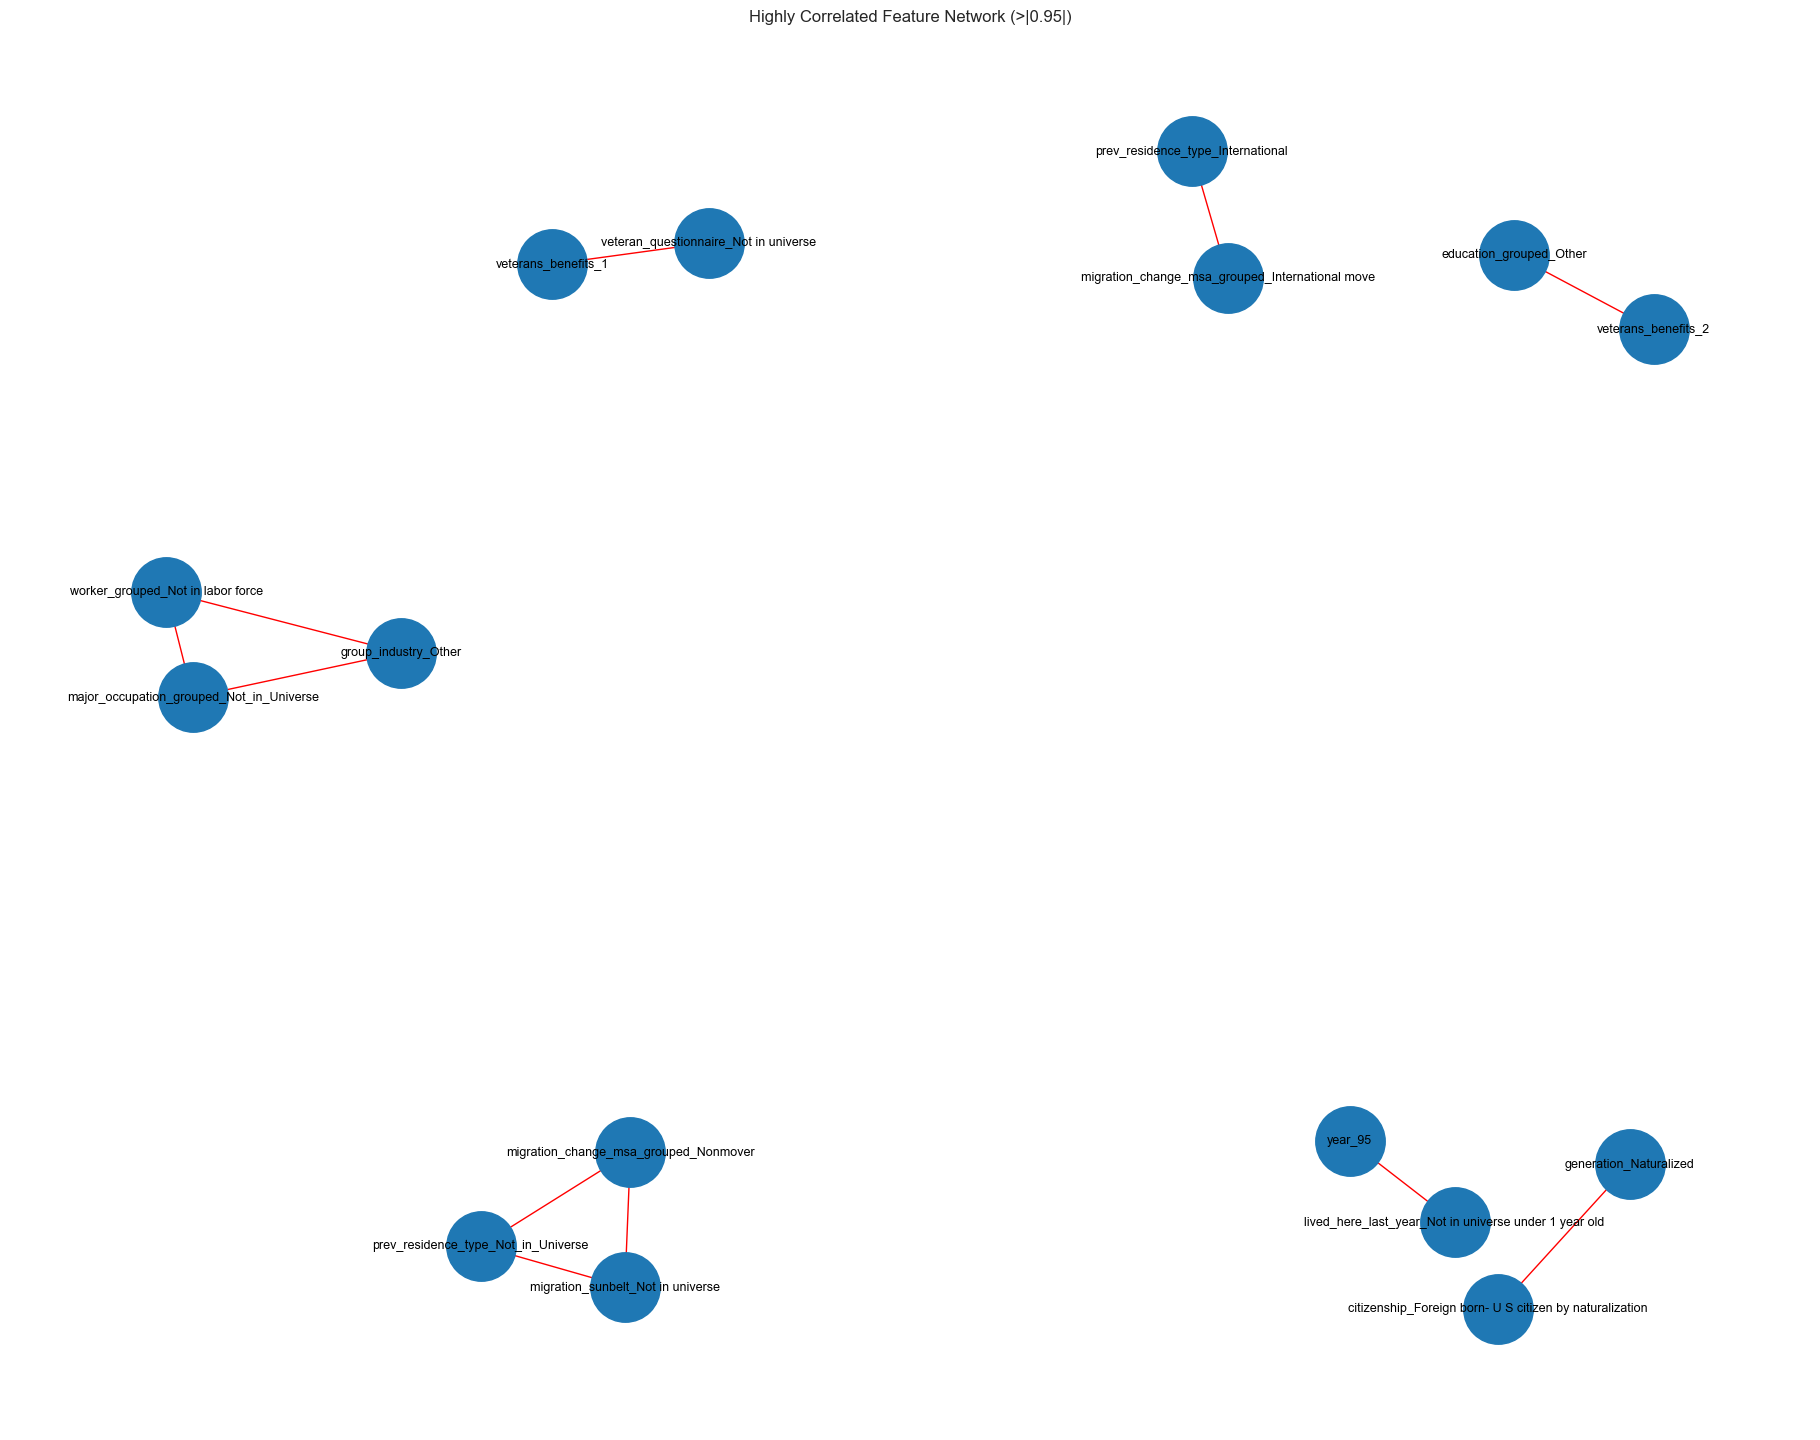

✅ Dropped 12 highly correlated columns.
Remaining columns in training data: 73
Remaining columns in testing data: 73


In [42]:
# ==========================================================
# 7️⃣ Visualize Highly Correlated Features as a Network
# ==========================================================
# Purpose:
# - Represent highly correlated features (>0.95) as a graph.
# - Each node is a feature, and an edge connects two features
#   that are highly correlated.
# - Helps visually identify clusters of redundant features.

import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

# Add edges for each highly correlated feature pair, weighted by correlation
for f1, f2, corr in high_corr_pairs:
    G.add_edge(f1, f2, weight=corr)

# Plot the network
plt.figure(figsize=(18, 14))
pos = nx.spring_layout(G, k=0.5, seed=42)  # Layout of nodes

nx.draw(
    G, pos,
    with_labels=True,
    node_size=2500,
    font_size=9,
    edge_color='red'
)

plt.title('Highly Correlated Feature Network (>|0.95|)')
plt.show()


# ==========================================================
# 8️⃣ Remove Highly Correlated Features
# ==========================================================
# Purpose:
# - Avoid multicollinearity by dropping redundant features.
# - For each high-correlation pair, we drop the second feature
#   (arbitrary choice; can choose based on domain knowledge).

# List of high correlation pairs identified from analysis
high_corr_pairs = [
    ('education_grouped_Other','veterans_benefits_2'),
    ('major_occupation_grouped_Not_in_Universe','worker_grouped_Not in labor force'),
    ('major_occupation_grouped_Not_in_Universe','group_industry_Other'),
    ('worker_grouped_Not in labor force','group_industry_Other'),
    ('prev_residence_type_International','migration_change_msa_grouped_International move'),
    ('prev_residence_type_Not_in_Universe','migration_change_msa_grouped_Nonmover'),
    ('prev_residence_type_Not_in_Universe','migration_sunbelt_Not in universe'),
    ('migration_change_msa_grouped_Nonmover','migration_sunbelt_Not in universe'),
    ('lived_here_last_year_Not in universe under 1 year','year_95'),
    ('generation_Naturalized','citizenship_Foreign born- U S citizen by naturalization'),
    ('veteran_questionnaire_Not in universe','veterans_benefits_1'),
    ('citizenship_Foreign born- U S citizen by naturalization','generation_Naturalized')
]

# Extract the second column from each pair to drop
cols_to_drop = [pair[1] for pair in high_corr_pairs]

# Drop the identified highly correlated columns from both training and testing datasets
# errors='ignore' ensures no error if a column is already missing
train_df_model = train_df_ready.drop(columns=cols_to_drop, errors='ignore')
test_df_model = test_df_ready.drop(columns=cols_to_drop, errors='ignore')

# Quick summary
print(f"✅ Dropped {len(cols_to_drop)} highly correlated columns.")
print("Remaining columns in training data:", train_df_model.shape[1])
print("Remaining columns in testing data:", test_df_model.shape[1])


In [43]:
train_df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 73 columns):
 #   Column                                                   Non-Null Count   Dtype  
---  ------                                                   --------------   -----  
 0   age                                                      199523 non-null  int64  
 1   weeks_worked                                             199523 non-null  int64  
 2   num_persons_worked_for_employer                          199523 non-null  int64  
 3   wage_per_hour_log                                        199523 non-null  float64
 4   capital_gains_log                                        199523 non-null  float64
 5   capital_losses_log                                       199523 non-null  float64
 6   dividends_from_stocks_log                                199523 non-null  float64
 7   target                                                   199523 non-null  int64  
 8   education_grou

Data Modeling : Building Logistic Regression Model

In [44]:
# Feature engineering
#   ↓
#Remove highly correlated features (>0.95)
#   ↓
#Compute VIF (numeric + encoded features)
#   ↓
#Drop VIF > 10 ONLY for linear models
#   ↓
#Model training
# 
# 
# Model 1 Using Logistic Regression after removing higly correlated variable 
# and since target has imbalanced data using smote we rerun the model and check the accuracy.
# 
# 
# ==========================================================
# Logistic Regression Modeling (Original vs SMOTE Balanced)
# ==========================================================

# -----------------------------
# Step 0: Install imbalanced-learn if needed
# -----------------------------
# !pip install imbalanced-learn
# This package provides SMOTE for handling class imbalance

# -----------------------------
# Step 1: Prepare Data
# -----------------------------
# Separate predictors (X) and target variable (y)
X = train_df_model.drop(columns='target')  # all features except target
y = train_df_model['target']               # target variable (income >50K or <=50K)

# Split the training data into train and validation sets
# stratify=y ensures the class distribution is preserved in both sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# Step 2: Logistic Regression on Original Data
# -----------------------------
# - max_iter=3000: allow sufficient iterations for convergence
# - class_weight='balanced': automatically adjusts weights to handle imbalance
# - random_state=42: ensures reproducibility

logreg_orig = LogisticRegression(max_iter=3000, class_weight='balanced', random_state=42)
logreg_orig.fit(X_train, y_train)  # Train the model

# Make predictions on the validation set
y_val_pred_orig_m1 = logreg_orig.predict(X_val)           # Predicted class labels
y_val_proba_orig_m1 = logreg_orig.predict_proba(X_val)[:, 1]  # Predicted probabilities for class 1 (>50K)

# Evaluate model performance
print("=== Logistic Regression on Original Data ===")
print(classification_report(y_val, y_val_pred_orig_m1))   # Precision, Recall, F1-score
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_orig_m1))        # True vs predicted
print("ROC AUC Score:", roc_auc_score(y_val, y_val_proba_orig_m1))  # Probability-based metric

# -----------------------------
# Step 3: Logistic Regression with SMOTE (Synthetic Minority Oversampling)
# -----------------------------
# - SMOTE generates synthetic examples of the minority class to balance the training data

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)  # Balanced training set

# Train logistic regression on SMOTE-balanced data
logreg_smote = LogisticRegression(max_iter=3000, random_state=42)
logreg_smote.fit(X_train_res, y_train_res)

# Make predictions on the validation set
y_val_pred_smote_m2 = logreg_smote.predict(X_val)
y_val_proba_smote_m2 = logreg_smote.predict_proba(X_val)[:, 1]

# Evaluate model performance
print("\n=== Logistic Regression with SMOTE ===")
print(classification_report(y_val, y_val_pred_smote_m2))  # Precision, Recall, F1-score
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_smote_m2))       # True vs predicted
print("ROC AUC Score:", roc_auc_score(y_val, y_val_proba_smote_m2))  # Probability-based metric


=== Logistic Regression on Original Data ===
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     37429
           1       0.27      0.89      0.42      2476

    accuracy                           0.84     39905
   macro avg       0.63      0.87      0.66     39905
weighted avg       0.95      0.84      0.88     39905

Confusion Matrix:
[[31498  5931]
 [  269  2207]]
ROC AUC Score: 0.9390420121655427


c:\Users\kazme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



=== Logistic Regression with SMOTE ===
              precision    recall  f1-score   support

           0       0.99      0.85      0.91     37429
           1       0.28      0.88      0.42      2476

    accuracy                           0.85     39905
   macro avg       0.63      0.86      0.67     39905
weighted avg       0.95      0.85      0.88     39905

Confusion Matrix:
[[31776  5653]
 [  303  2173]]
ROC AUC Score: 0.937383956381217


In [50]:
# For original logistic regression
feature_weights = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logreg_orig.coef_[0]
})

# Sort by magnitude to see most influential factors
feature_weights['Absolute'] = feature_weights['Coefficient'].abs()
feature_weights.sort_values(by='Absolute', ascending=False, inplace=True)
feature_weights


,Feature,Coefficient,Absolute
11,education_grouped_PostGraduate,2.513321,2.513321
40,unemp_reason_grp_New_Entrant,2.396795,2.396795
10,education_grouped_Other,-2.083203,2.083203
48,household_role_Minor_Dependent,-1.947207,1.947207
8,education_grouped_Graduate,1.866307,1.866307
23,sex_Male,1.243794,1.243794
7,education_grouped_College,1.150427,1.150427
51,household_role_Primary_Household_Adult,1.126777,1.126777
63,family_members_under_18_Mother only present,-1.044292,1.044292
45,filing_type_nan,-0.979276,0.979276


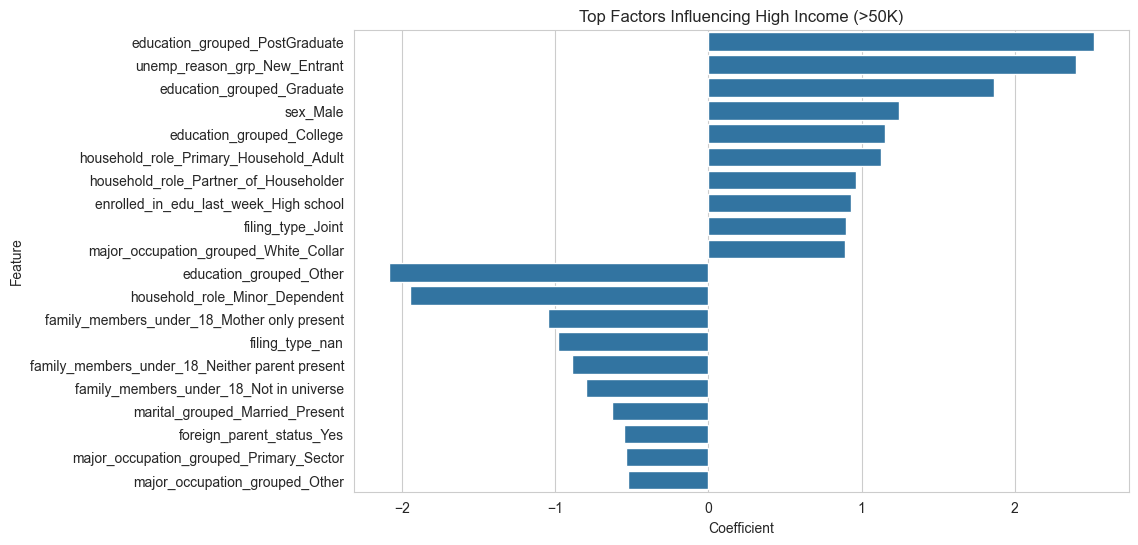

In [51]:
# Top 10 positive influences
top_pos = feature_weights.sort_values(by='Coefficient', ascending=False).head(10)

# Top 10 negative influences
top_neg = feature_weights.sort_values(by='Coefficient', ascending=True).head(10)

# Combine for plotting
top_features = pd.concat([top_pos, top_neg])

plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=top_features)
plt.title('Top Factors Influencing High Income (>50K)')
plt.show()



In [52]:
feature_weights_smote = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logreg_smote.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

# Sort by magnitude to see most influential factors
feature_weights_smote['Absolute'] = feature_weights_smote['Coefficient'].abs()
feature_weights_smote.sort_values(by='Absolute', ascending=False, inplace=True)
feature_weights_smote


,Feature,Coefficient,Absolute
40,unemp_reason_grp_New_Entrant,2.932588,2.932588
11,education_grouped_PostGraduate,2.906800,2.906800
10,education_grouped_Other,-2.767665,2.767665
8,education_grouped_Graduate,2.109418,2.109418
48,household_role_Minor_Dependent,-2.046923,2.046923
23,sex_Male,1.474795,1.474795
51,household_role_Primary_Household_Adult,1.341074,1.341074
63,family_members_under_18_Mother only present,-1.277599,1.277599
7,education_grouped_College,1.237483,1.237483
43,filing_type_Joint,1.229784,1.229784


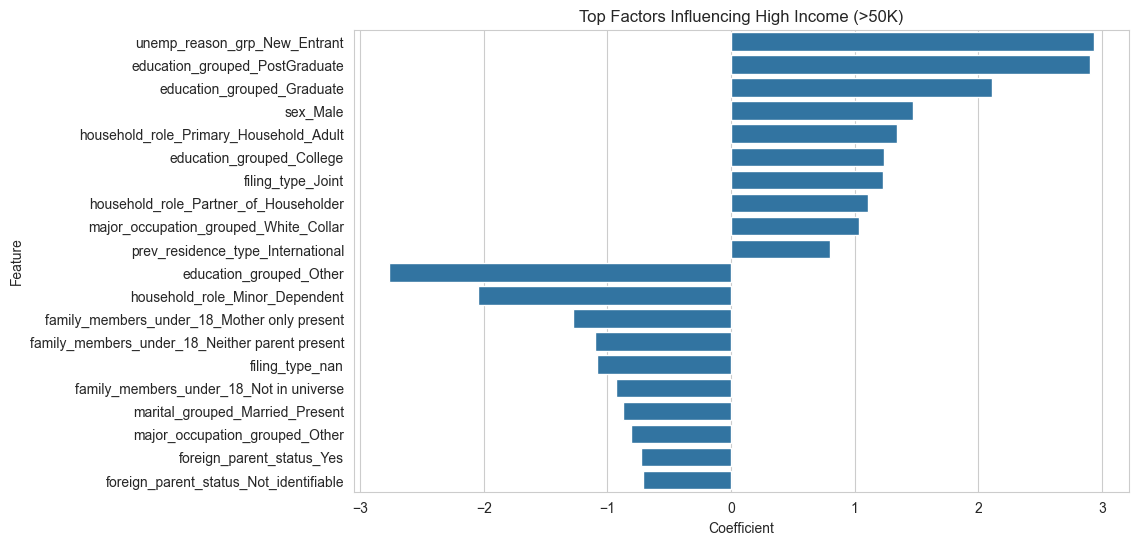

In [53]:
# Top 10 positive influences
top_pos = feature_weights_smote.sort_values(by='Coefficient', ascending=False).head(10)

# Top 10 negative influences
top_neg = feature_weights_smote.sort_values(by='Coefficient', ascending=True).head(10)

# Combine for plotting
top_features = pd.concat([top_pos, top_neg])

plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=top_features)
plt.title('Top Factors Influencing High Income (>50K)')
plt.show()

Data Modeling : Random Forest

In [55]:
# ==========================================================
# Random Forest Classifier
# ==========================================================


# -----------------------------
# Step 1: Prepare Data
# -----------------------------
# Separate predictors (X) and target (y)
X = train_df_model.drop(columns='target')  # all features except target
y = train_df_model['target']               # target variable (>50K or <=50K)

# Split the data into train and validation sets
# stratify=y preserves the class distribution in both sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# Step 2: Initialize Random Forest
# -----------------------------
# n_estimators=300 : number of trees in the forest
# max_depth=15 : maximum depth of each tree to prevent overfitting
# min_samples_leaf=50 : minimum samples per leaf to avoid tiny leaves
# class_weight='balanced' : handle class imbalance automatically
# n_jobs=-1 : use all CPU cores for faster training
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_leaf=50,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# -----------------------------
# Step 3: Train the Model
# -----------------------------
rf.fit(X_train, y_train)

# -----------------------------
# Step 4: Make Predictions
# -----------------------------
y_val_pred_m3 = rf.predict(X_val)           # Predicted class labels
y_val_proba_m3 = rf.predict_proba(X_val)[:, 1]  # Predicted probabilities for class 1 (>50K)

# -----------------------------
# Step 5: Evaluate Model Performance
# -----------------------------
print("=== Random Forest ===")
print(classification_report(y_val, y_val_pred_m3))  # Precision, Recall, F1-score per class
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_m3))       # True vs predicted labels
print("ROC AUC:", roc_auc_score(y_val, y_val_proba_m3))  # Overall discrimination ability


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.99      0.83      0.91     37429
           1       0.26      0.91      0.41      2476

    accuracy                           0.84     39905
   macro avg       0.63      0.87      0.66     39905
weighted avg       0.95      0.84      0.87     39905

Confusion Matrix:
[[31144  6285]
 [  235  2241]]
ROC AUC: 0.9420387306482825


In [56]:
from sklearn.model_selection import cross_val_score

# 1. Run 5-Fold Cross-Validation on the training data
# This splits the data 5 times, trains 5 models, and gives 5 scores
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')

# 2. Check the results
print(f"Individual CV Scores: {cv_scores}")
print(f"Average AUC Score: {cv_scores.mean():.4f}")
print(f"Stability (Std Dev): {cv_scores.std():.4f}")

Individual CV Scores: [0.93876245 0.94080014 0.93974092 0.93950464 0.93839339]
Average AUC Score: 0.9394
Stability (Std Dev): 0.0008


C:\Users\kazme\AppData\Local\Temp\ipykernel_27736\2441833846.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


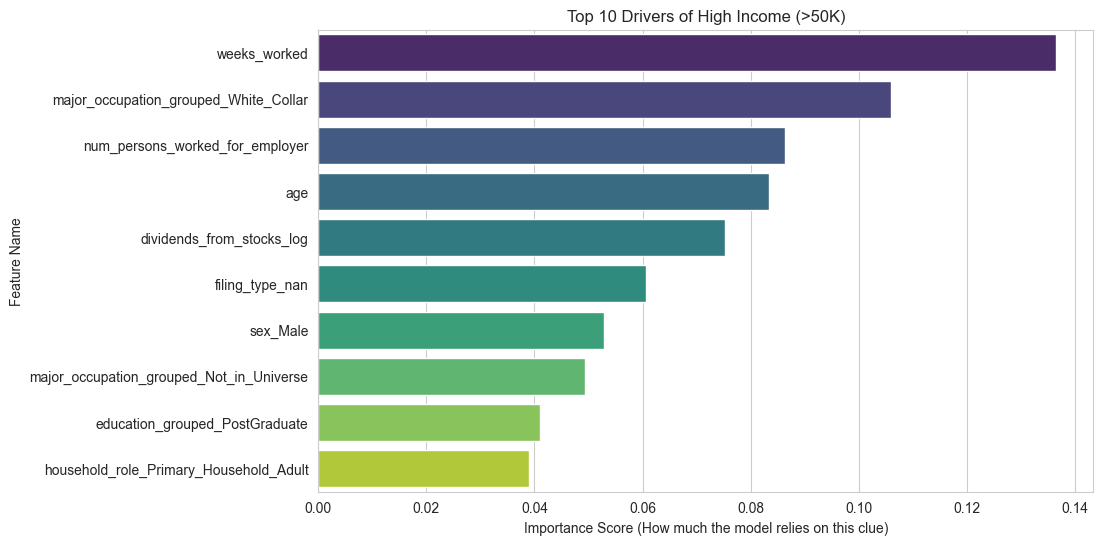

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Get the importance scores from your trained model
importances = rf.feature_importances_
feature_names = X.columns

# 2. Create a DataFrame for easy plotting
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(10) # Top 10

# 3. Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Top 10 Drivers of High Income (>50K)')
plt.xlabel('Importance Score (How much the model relies on this clue)')
plt.ylabel('Feature Name')
plt.show()

Data Modeling : XGBoost Classifier

In [ ]:
# ==========================================================
# XGBoost Classifier
# ==========================================================



# -----------------------------
# Step 1: Prepare Data
# -----------------------------
# Separate predictors (X) and target (y)
X = train_df_model.drop(columns='target')  # all features except target
y = train_df_model['target']               # target variable (>50K or <=50K)

# Split the dataset into training and validation sets
# stratify=y ensures the same class distribution in both sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to NumPy arrays of type float32 (required by XGBoost for faster computation)
X_train_np = X_train.values.astype(np.float32)
X_val_np = X_val.values.astype(np.float32)
y_train_np = y_train.values
y_val_np = y_val.values

# -----------------------------
# Step 2: Handle Class Imbalance
# -----------------------------
# Calculate the scale_pos_weight to balance the positive class (income >50K)
# This gives more importance to the minority class during training
scale_pos_weight = (y_train_np == 0).sum() / (y_train_np == 1).sum()

# -----------------------------
# Step 3: Initialize XGBoost Classifier
# -----------------------------
# n_estimators=300 : number of trees
# max_depth=6 : maximum depth of each tree
# learning_rate=0.05 : step size shrinkage
# subsample=0.8 : fraction of samples used per tree (prevents overfitting)
# colsample_bytree=0.8 : fraction of features per tree (prevents overfitting)
# scale_pos_weight : handle class imbalance
# eval_metric='auc' : optimize for AUC
# n_jobs=-1 : use all CPU cores
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

# -----------------------------
# Step 4: Train the Model
# -----------------------------
xgb.fit(X_train_np, y_train_np)

# -----------------------------
# Step 5: Make Predictions
# -----------------------------
y_val_pred_m4 = xgb.predict(X_val_np)           # predicted class labels
y_val_proba_m4 = xgb.predict_proba(X_val_np)[:, 1]  # predicted probabilities for class 1 (>50K)

# -----------------------------
# Step 6: Evaluate Model Performance
# -----------------------------
print("=== XGBoost ===")
print(classification_report(y_val_np, y_val_pred_m4))  # precision, recall, F1-score
print("Confusion Matrix:")
print(confusion_matrix(y_val_np, y_val_pred_m4))       # true vs predicted
print("ROC AUC:", roc_auc_score(y_val_np, y_val_proba_m4))  # discrimination ability


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     37429
           1       0.31      0.89      0.46      2476

    accuracy                           0.87     39905
   macro avg       0.65      0.88      0.69     39905
weighted avg       0.95      0.87      0.90     39905

Confusion Matrix:
[[32516  4913]
 [  273  2203]]
ROC AUC: 0.9501148021729974


Model Assessment


=== Model Comparison Table ===
                                     Model  Accuracy  Precision_Class1  \
0  Model 1: Logistic Regression (Original)  0.844631          0.271197   
1     Model 2: Logistic Regression (SMOTE)  0.850746          0.277664   
2                   Model 3: Random Forest  0.836612          0.262843   
3                         Model 4: XGBoost  0.870041          0.309584   

   Recall_Class1  F1_Class1   ROC_AUC  
0       0.891357   0.415866  0.939042  
1       0.877625   0.421860  0.937384  
2       0.905089   0.407380  0.942039  
3       0.889742   0.459341  0.950115  


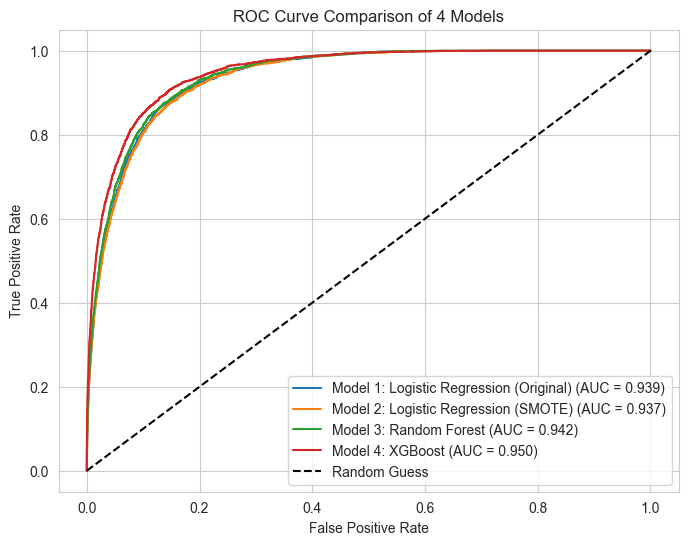

In [662]:
# ===============================
# Model Comparison & ROC Curves
# ===============================


# -------------------------------
# Step 1: Collect predictions from all models
# -------------------------------
# Each model has its predicted class labels and predicted probabilities for class 1 (income >50K)
model_results = {
    "Model 1: Logistic Regression (Original)": {"y_pred": y_val_pred_orig_m1, "y_proba": y_val_proba_orig_m1},
    "Model 2: Logistic Regression (SMOTE)": {"y_pred": y_val_pred_smote_m2, "y_proba": y_val_proba_smote_m2},
    "Model 3: Random Forest": {"y_pred": y_val_pred_m3, "y_proba": y_val_proba_m3},
    "Model 4: XGBoost": {"y_pred": y_val_pred_m4, "y_proba": y_val_proba_m4}
}

# -------------------------------
# Step 2: Build a summary comparison table
# -------------------------------
# For each model:
#   - Accuracy: overall correct predictions
#   - Precision_Class1: proportion of predicted high-income individuals that are correct
#   - Recall_Class1: proportion of actual high-income individuals correctly predicted
#   - F1_Class1: harmonic mean of precision and recall for class 1
#   - ROC_AUC: measure of discrimination ability
summary = []

for name, res in model_results.items():
    # Get detailed classification metrics as a dictionary
    report = classification_report(y_val, res["y_pred"], output_dict=True)
    auc = roc_auc_score(y_val, res["y_proba"])
    
    # Append summary metrics for class 1 (income >50K)
    summary.append({
        "Model": name,
        "Accuracy": (y_val == res["y_pred"]).mean(),
        "Precision_Class1": report['1']['precision'],
        "Recall_Class1": report['1']['recall'],
        "F1_Class1": report['1']['f1-score'],
        "ROC_AUC": auc
    })

# Convert summary into a DataFrame for easy visualization
summary_df = pd.DataFrame(summary)
print("\n=== Model Comparison Table ===")
print(summary_df)

# -------------------------------
# Step 3: Plot ROC curves for all models
# -------------------------------
plt.figure(figsize=(8,6))

for name, res in model_results.items():
    # Compute False Positive Rate (FPR) and True Positive Rate (TPR)
    fpr, tpr, _ = roc_curve(y_val, res["y_proba"])
    auc = roc_auc_score(y_val, res["y_proba"])
    
    # Plot each model's ROC curve with AUC in the legend
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# Plot diagonal line representing random guessing
plt.plot([0,1], [0,1], 'k--', label='Random Guess')

# Labels and formatting
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of 4 Models")
plt.legend()
plt.grid(True)
plt.show()


“After selecting XGBoost as the best-performing model, I ran inference on the holdout test set. When ground-truth labels were available, I evaluated performance using ROC-AUC, precision, recall, and confusion matrices. Otherwise, predictions were stored for downstream analysis and decision-making.”

In [663]:
# ================================
# Align Test Features with Train
# ================================

# Save the list of feature names used during training
# This ensures that the model sees the exact same feature set at prediction time
train_features = train_df_model.drop(columns=['target']).columns

# Reindex the test dataframe to match training features
# - Missing columns in test data are created and filled with 0
# - Extra columns in test data (not seen during training) are dropped
X_test = test_df_model.reindex(columns=train_features, fill_value=0)

# Convert test features to NumPy array and float32
# Required for compatibility and performance with XGBoost
X_test_np = X_test.values.astype(np.float32)

# Sanity check to confirm perfect feature alignment
print("Train feature count:", len(train_features))
print("Test feature count:", X_test_np.shape[1])


Train feature count: 72
Test feature count: 72


Model Evaluation : Accuracy Check on Testing dataset

=== XGBoost on Test Data ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     93576
           1       0.73      0.43      0.54      6186

    accuracy                           0.95     99762
   macro avg       0.84      0.71      0.76     99762
weighted avg       0.95      0.95      0.95     99762

Confusion Matrix:
[[92585   991]
 [ 3549  2637]]
ROC AUC: 0.9500998344791282


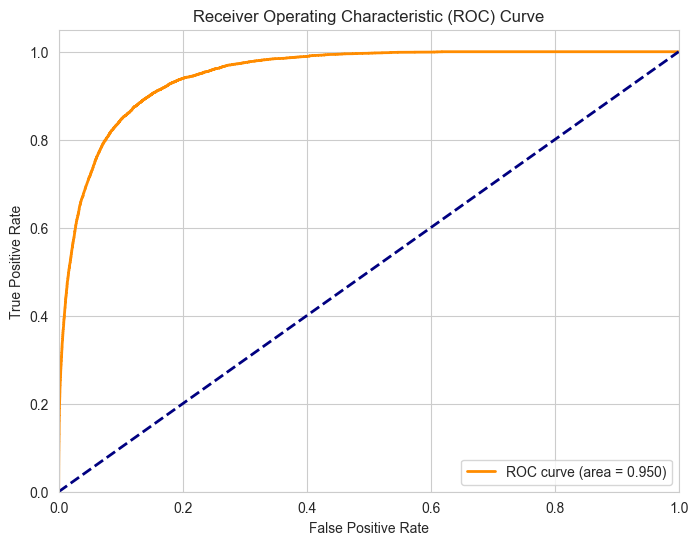

In [664]:
##Before making predictions, I explicitly align test features with the training feature set to ensure identical feature ordering and dimensionality. 
#This avoids silent prediction errors caused by one-hot encoding mismatches and makes the pipeline production-safe.”

# ================================
# 1️⃣ Prepare Test Data
# ================================
# Drop target if present, align features with training model
X_test = test_df_model.drop(columns=['target'], errors='ignore')

# Convert to NumPy array and float32 for XGBoost
X_test_np = X_test.values.astype(np.float32)

# ================================
# 2️⃣ Predict using trained XGBoost model
# ================================
y_test_pred = xgb_model.predict(X_test_np)           # Predicted class labels
y_test_proba = xgb_model.predict_proba(X_test_np)[:, 1]  # Predicted probabilities for class 1

# ================================
# 3️⃣ Create results DataFrame
# ================================
test_results = test_df_model.copy()
test_results['target_pred'] = y_test_pred
test_results['target_proba'] = y_test_proba

# ================================
# 4️⃣ Evaluate if actual labels are available
# ================================
if 'target' in test_df_model.columns:
    print("=== XGBoost on Test Data ===")
    print(classification_report(test_df_model['target'], y_test_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(test_df_model['target'], y_test_pred))
    print("ROC AUC:", roc_auc_score(test_df_model['target'], y_test_proba))
    
    # Optional: plot ROC curve
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(test_df_model['target'], y_test_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("Predictions saved in 'test_results' DataFrame")


Model Explainabilty & Feature Importance

Model type: <class 'xgboost.sklearn.XGBClassifier'>


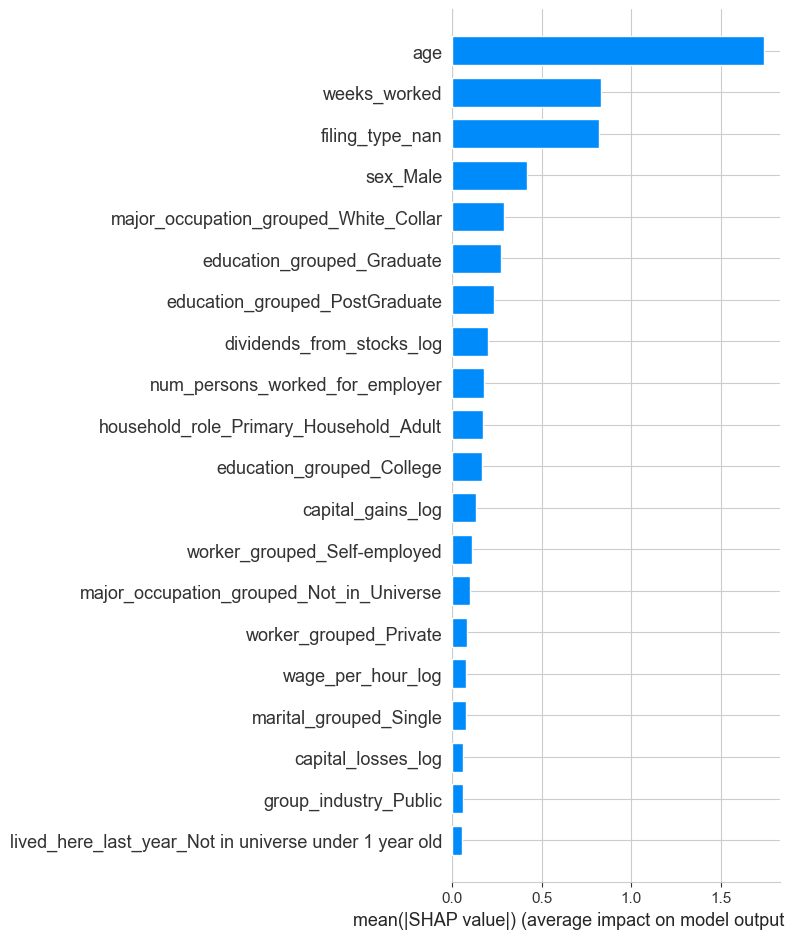

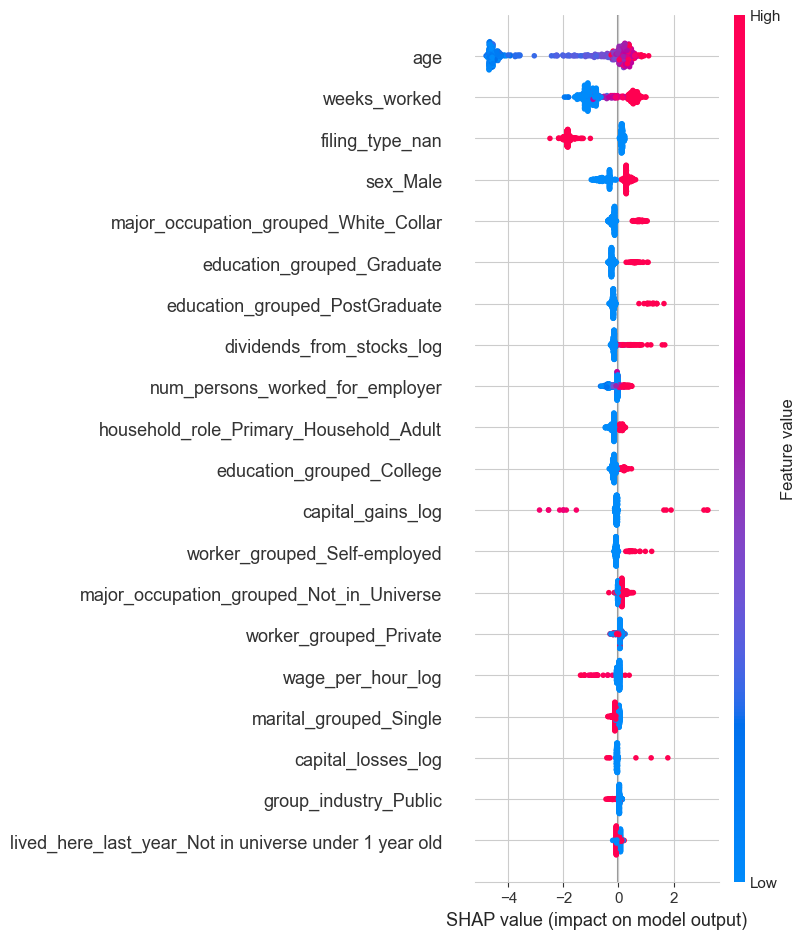

In [ ]:
# ==========================================================
# XGBoost Feature Importance & Model Explainability using SHAP
# ==========================================================
# Goal:
# - Identify which features most strongly influence income > $50K
# - Explain both global and individual model behavior
# - Provide transparency for stakeholders (critical for Dataiku role)



# ----------------------------------------------------------
# 1️⃣ Verify that the trained model is an XGBoost classifier
# ----------------------------------------------------------
# This avoids a common mistake where the xgboost *module*
# is used instead of the trained model instance
print("Model type:", type(xgb_model))
# Expected output:
# <class 'xgboost.sklearn.XGBClassifier'>

# ----------------------------------------------------------
# 2️⃣ Initialize SHAP TreeExplainer
# ----------------------------------------------------------
# TreeExplainer is optimized for tree-based models
# (XGBoost, Random Forest, LightGBM)
explainer = shap.TreeExplainer(xgb_model)

# ----------------------------------------------------------
# 3️⃣ Select a representative sample of training data
# ----------------------------------------------------------
# SHAP can be computationally expensive on large datasets
# Using a small but representative sample gives stable explanations
X_sample = X_train_np[:500]

# Preserve feature names for interpretability
feature_names = X_train.columns

# ----------------------------------------------------------
# 4️⃣ Compute SHAP values
# ----------------------------------------------------------
# SHAP values quantify each feature's contribution
# to pushing a prediction toward class 1 (> $50K) or class 0 (≤ $50K)
shap_values = explainer.shap_values(X_sample)

# For binary classification, SHAP may return a list:
# [class_0_values, class_1_values]
# We focus on class 1 (income > $50K)
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# ----------------------------------------------------------
# 5️⃣ Global Feature Importance (Mean Absolute SHAP Values)
# ----------------------------------------------------------
# This bar plot answers:
# "Which features matter the most overall?"
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)

# ----------------------------------------------------------
# 6️⃣ Detailed SHAP Impact Plot (Direction + Magnitude)
# ----------------------------------------------------------
# This plot answers:
# - Which features increase income probability?
# - Which features decrease it?
# - How feature values interact with predictions
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=feature_names,
    show=True
)
